# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [25]:
import os
import sys
import piexif

import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 
import json

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [26]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [27]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3774837127962413491, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9760810599
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3671018580322309710
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [28]:
#import keras
#import tensorflow as tf
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)


## Configurations

In [29]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [30]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [31]:
def seperate_x_and_y_points(poly):   
    poly = ''.join(poly);
    a = poly.split(',')            
    x_points = a[0::2]            
    y_points = a[1::2]
    x_points = list(map(int, x_points))
    y_points = list(map(int, y_points))
    return x_points, y_points

class BalloonDataset(utils.Dataset):
    whichDataSetToLoad = ''
        
    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
       # assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "instances.json")))        
       # print(dataset_dir)
        print()
        
        for  i in range(len(annotations['images'])):
            polygon = list(dict())
            polygon = [{'name': 'polygon', 'all_points_x': [], 'all_points_y': []}]
            polygon[0]['name'] ='text'
            
            #print(polygon)
            file_name = annotations['images'][i]['file_name']
            #print(file_name)
            width = int(annotations['images'][i]['width'])
            height = int(annotations['images'][i]['height'])
           # print(file_name, width, height)
        
            if(self.whichDataSetToLoad != 'ground_truth'):            
                image_path = os.path.join(dataset_dir, file_name)+ '.jpg'  
                #print(image_path)
            if(self.whichDataSetToLoad == 'ground_truth'):   
                image_path = os.path.join(dataset_dir, file_name)+ '.png'  
            #print(image_path)
            segmentation = annotations['annotations'][i]['segmentation']
            polygons = []
            for poly in segmentation:   
                x_points, y_points = seperate_x_and_y_points(poly)                          
                polygon = {'name': 'polygon', 'all_points_x': [], 'all_points_y': []}
                polygon['name'] ='text'
                polygon['all_points_x'] = x_points
                polygon['all_points_y'] = y_points         
                polygons.append(polygon)
            #print(polygons)
            self.add_image(
                    "balloon",
                    image_id=file_name,  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons)
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
        


In [32]:
# Training dataset
dataset_train = BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_train.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "train")
dataset_train.prepare()

# Validation dataset
dataset_val =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_val.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "val")
dataset_val.prepare()


# Test dataset
dataset_test =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_test.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "test")
dataset_test.prepare()



In [33]:

# Training dataset
dataset_train_gt = BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_train_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "train")
dataset_train_gt.prepare()

# Validation dataset
dataset_val_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_val_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "val")
dataset_val_gt.prepare()


# Test dataset
dataset_test_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_test_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "test")
dataset_test_gt.prepare()



##  Loading ground truth mask to show that masks are loading correctly 

34
[21  9 28 13 25  3 28 17 24 11]
[1 1]


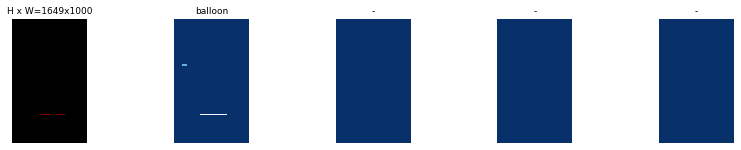

[1 1 1 1 1 1 1 1]


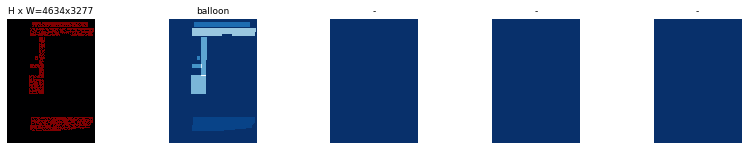

[1 1 1]


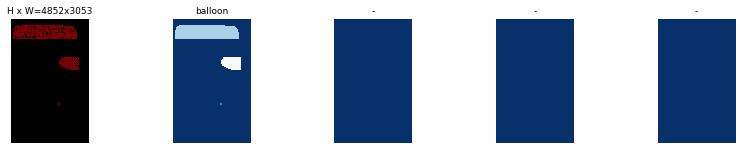

[1]


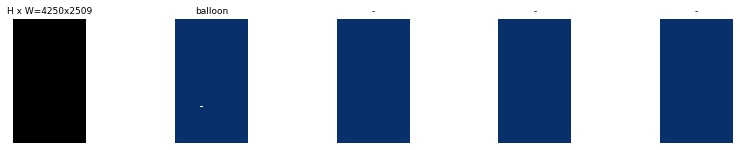

[1 1 1 1 1 1]


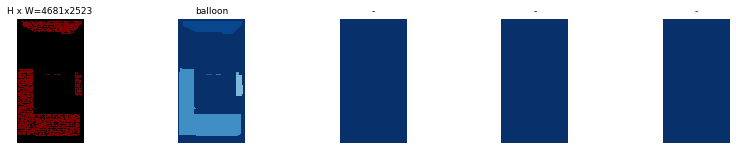

[1 1 1 1 1 1]


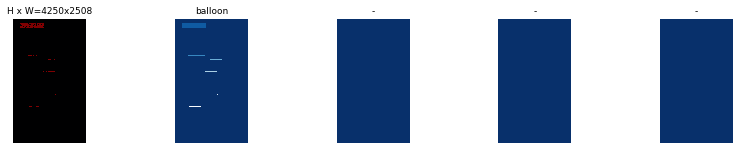

[1 1 1]


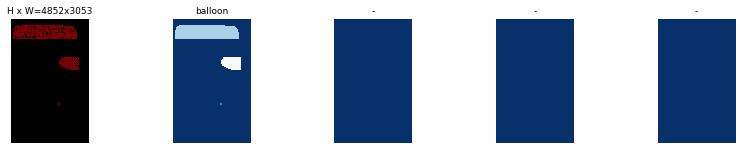

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


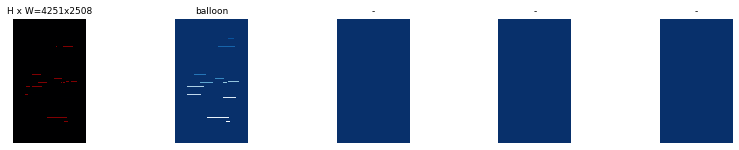

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


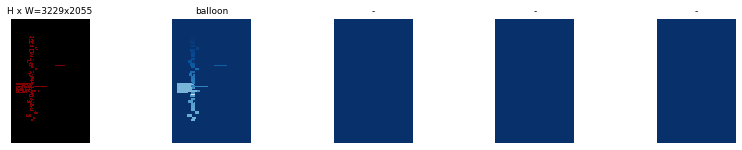

[1 1 1 1 1 1]


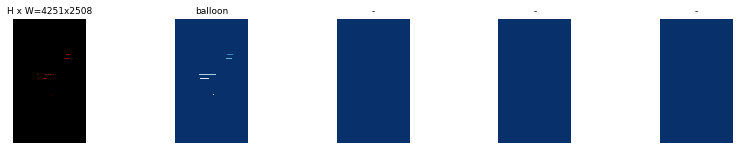

In [10]:
# Loading ground truth mask to show that masks are loading correctly
# Load and display random samples
print(dataset_train_gt.num_images)
image_ids = np.random.choice(dataset_train_gt.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train_gt.load_image(image_id)
    mask, class_ids = dataset_train_gt.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train_gt.class_names)

##  Loading Training Images mask to show that masks are loading correctly 

34
[21 31  3  7 30 24  5 26  8 30]
[1 1]


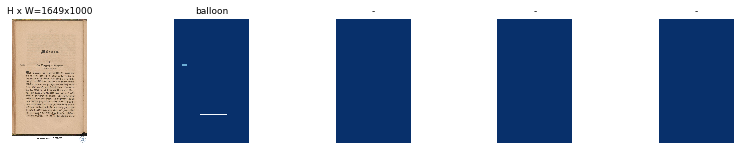

[1 1 1 1 1 1 1]


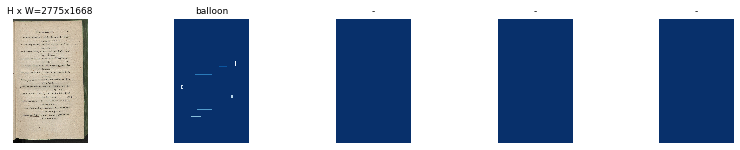

[1 1 1 1 1 1]


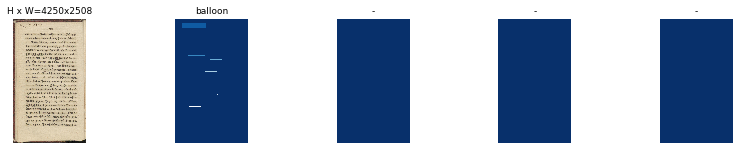

[1 1 1 1 1 1 1 1 1]


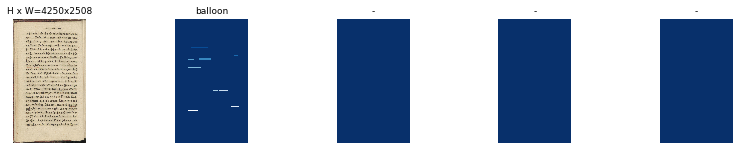

[1 1 1 1 1 1 1 1 1]


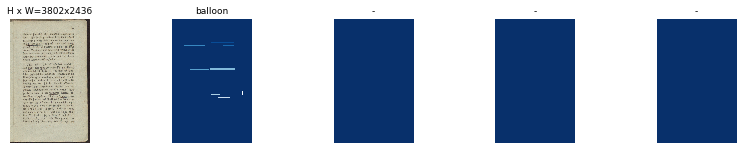

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


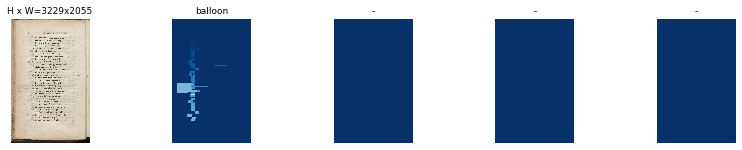

[1 1 1 1 1 1 1]


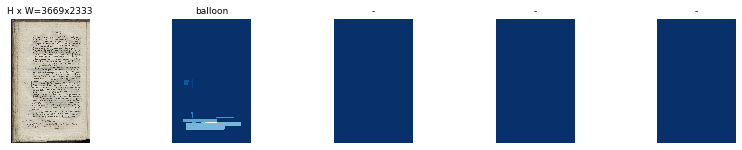

[1 1 1 1 1 1 1 1 1]


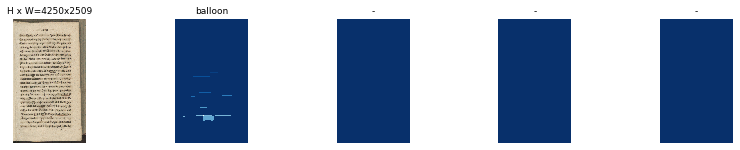

[1 1 1 1 1 1 1 1 1 1 1 1]


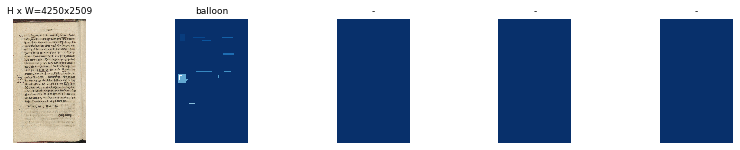

[1 1 1 1 1 1 1 1 1]


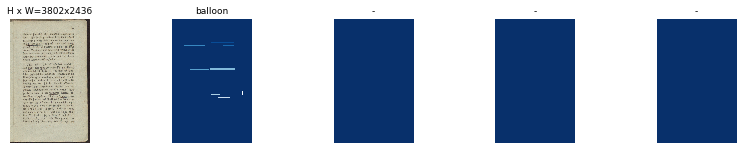

In [11]:

# Load and display random samples
print(dataset_train.num_images)
image_ids = np.random.choice(dataset_train.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [34]:
# Applying Augmentation

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)


seq = iaa.Sequential([    
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.

   
], random_order=True) # apply augmenters in random order

## Create Model

In [35]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [36]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 200


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads', augmentation= seq)





Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190820T2212/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 26/100 [======>.......................] - ETA: 2:42 - loss: 6.5044 - rpn_class_loss: 1.4190 - rpn_bbox_loss: 3.0361 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.8527 - mrcnn_mask_loss: 1.1593

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 2:18 - loss: 6.1116 - rpn_class_loss: 1.2765 - rpn_bbox_loss: 2.9067 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 1.0861

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 31/100 [========>.....................] - ETA: 2:13 - loss: 6.0218 - rpn_class_loss: 1.2448 - rpn_bbox_loss: 2.8742 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.7968 - mrcnn_mask_loss: 1.0706

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 2:08 - loss: 5.9364 - rpn_class_loss: 1.2154 - rpn_bbox_loss: 2.8433 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.7862 - mrcnn_mask_loss: 1.0557

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 2:00 - loss: 5.7586 - rpn_class_loss: 1.1626 - rpn_bbox_loss: 2.7647 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.7682 - mrcnn_mask_loss: 1.0286

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 1:49 - loss: 5.5249 - rpn_class_loss: 1.0918 - rpn_bbox_loss: 2.6576 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.7489 - mrcnn_mask_loss: 0.9924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 1s - loss: 4.1179 - rpn_class_loss: 0.5959 - rpn_bbox_loss: 2.1158 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.6497 - mrcnn_mask_loss: 0.7112

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

100/100 [==============================] - 121s 1s/step - loss: 4.1107 - rpn_class_loss: 0.5924 - rpn_bbox_loss: 2.1147 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.6487 - mrcnn_mask_loss: 0.7094 - val_loss: 3.6083 - val_rpn_class_loss: 0.1537 - val_rpn_bbox_loss: 1.6053 - val_mrcnn_class_loss: 0.1584 - val_mrcnn_bbox_loss: 1.0045 - val_mrcnn_mask_loss: 0.6864
Epoch 2/100
 65/100 [==================>...........] - ETA: 18s - loss: 3.1825 - rpn_class_loss: 0.2189 - rpn_bbox_loss: 1.8307 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.5711 - mrcnn_mask_loss: 0.4778

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 3.1534 - rpn_class_loss: 0.2153 - rpn_bbox_loss: 1.8024 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.4760

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 3.1573 - rpn_class_loss: 0.2158 - rpn_bbox_loss: 1.8064 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.5709 - mrcnn_mask_loss: 0.4758

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 14s - loss: 3.1480 - rpn_class_loss: 0.2139 - rpn_bbox_loss: 1.8034 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.5673 - mrcnn_mask_loss: 0.4736

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 3.1439 - rpn_class_loss: 0.2126 - rpn_bbox_loss: 1.7998 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.5684 - mrcnn_mask_loss: 0.4725

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 11s - loss: 3.1407 - rpn_class_loss: 0.2112 - rpn_bbox_loss: 1.7994 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.5690 - mrcnn_mask_loss: 0.4710

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 3.1397 - rpn_class_loss: 0.2109 - rpn_bbox_loss: 1.7996 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.4712

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 3.1351 - rpn_class_loss: 0.2091 - rpn_bbox_loss: 1.7952 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.5705 - mrcnn_mask_loss: 0.4696

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 554ms/step - loss: 3.1574 - rpn_class_loss: 0.2059 - rpn_bbox_loss: 1.8168 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.4879 - val_loss: 3.1173 - val_rpn_class_loss: 0.1887 - val_rpn_bbox_loss: 1.6448 - val_mrcnn_class_loss: 0.0547 - val_mrcnn_bbox_loss: 0.7104 - val_mrcnn_mask_loss: 0.5187
Epoch 3/100
100/100 [==============================] - 57s 571ms/step - loss: 2.8260 - rpn_class_loss: 0.1800 - rpn_bbox_loss: 1.6492 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.4442 - mrcnn_mask_loss: 0.4673 - val_loss: 2.9505 - val_rpn_class_loss: 0.1342 - val_rpn_bbox_loss: 1.9646 - val_mrcnn_class_loss: 0.0078 - val_mrcnn_bbox_loss: 0.4702 - val_mrcnn_mask_loss: 0.3738
Epoch 4/100
 51/100 [==============>...............] - ETA: 26s - loss: 2.4822 - rpn_class_loss: 0.1443 - rpn_bbox_loss: 1.4023 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.4408

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 23s - loss: 2.4911 - rpn_class_loss: 0.1483 - rpn_bbox_loss: 1.4064 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.4461

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 2.4694 - rpn_class_loss: 0.1466 - rpn_bbox_loss: 1.3900 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.4422

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 17s - loss: 2.4242 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 1.3667 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.4322

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 2.4190 - rpn_class_loss: 0.1430 - rpn_bbox_loss: 1.3679 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.3756 - mrcnn_mask_loss: 0.4309

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 2.4137 - rpn_class_loss: 0.1424 - rpn_bbox_loss: 1.3692 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.4278

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 2.4127 - rpn_class_loss: 0.1404 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.3688 - mrcnn_mask_loss: 0.4197

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 2.4234 - rpn_class_loss: 0.1397 - rpn_bbox_loss: 1.3994 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.3693 - mrcnn_mask_loss: 0.4182

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 2.4991 - rpn_class_loss: 0.1336 - rpn_bbox_loss: 1.4901 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.3726 - mrcnn_mask_loss: 0.4121 - val_loss: 2.8100 - val_rpn_class_loss: 0.2151 - val_rpn_bbox_loss: 2.3913 - val_mrcnn_class_loss: 0.0096 - val_mrcnn_bbox_loss: 0.1092 - val_mrcnn_mask_loss: 0.0848
Epoch 5/100
100/100 [==============================] - 57s 569ms/step - loss: 2.1757 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.3700 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.3619 - val_loss: 3.2082 - val_rpn_class_loss: 0.2353 - val_rpn_bbox_loss: 2.2721 - val_mrcnn_class_loss: 0.0244 - val_mrcnn_bbox_loss: 0.2902 - val_mrcnn_mask_loss: 0.3863
Epoch 6/100
 51/100 [==============>...............] - ETA: 26s - loss: 2.1888 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 1.2122 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.3839

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 2.1797 - rpn_class_loss: 0.1472 - rpn_bbox_loss: 1.2032 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.3870

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 2.1533 - rpn_class_loss: 0.1404 - rpn_bbox_loss: 1.1902 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3878

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 19s - loss: 2.1395 - rpn_class_loss: 0.1379 - rpn_bbox_loss: 1.1778 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3874

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 2.0948 - rpn_class_loss: 0.1326 - rpn_bbox_loss: 1.1510 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.3870

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 2.0758 - rpn_class_loss: 0.1277 - rpn_bbox_loss: 1.1466 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.3832

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 2.0624 - rpn_class_loss: 0.1249 - rpn_bbox_loss: 1.1428 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.3810

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 2.0802 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 1.1681 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.3788

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 2.0816 - rpn_class_loss: 0.1242 - rpn_bbox_loss: 1.1786 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.2945 - mrcnn_mask_loss: 0.3754 - val_loss: 2.9968 - val_rpn_class_loss: 0.1428 - val_rpn_bbox_loss: 1.6232 - val_mrcnn_class_loss: 0.0298 - val_mrcnn_bbox_loss: 0.4131 - val_mrcnn_mask_loss: 0.7879
Epoch 7/100
 62/100 [=================>............] - ETA: 20s - loss: 2.2567 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.3787 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.3538

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 20s - loss: 2.2558 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 1.3759 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.3539

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 2.2625 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.3976 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.3494

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 13s - loss: 2.2545 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 1.3953 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.3477

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 8s - loss: 2.2350 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.3931 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.3426

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 2.2356 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.3975 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3417

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 2.2250 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 1.3888 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3417

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 2.2166 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.3851 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.3415

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 2.2180 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.3420 - val_loss: 3.0999 - val_rpn_class_loss: 0.1432 - val_rpn_bbox_loss: 2.0379 - val_mrcnn_class_loss: 0.0184 - val_mrcnn_bbox_loss: 0.4653 - val_mrcnn_mask_loss: 0.4351
Epoch 8/100
 86/100 [========================>.....] - ETA: 7s - loss: 1.9424 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.1450 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 0.3395

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 4s - loss: 1.9460 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.1552 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.2564 - mrcnn_mask_loss: 0.3381

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 63s 632ms/step - loss: 1.9522 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 1.1643 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.3376 - val_loss: 2.6568 - val_rpn_class_loss: 0.1481 - val_rpn_bbox_loss: 1.6798 - val_mrcnn_class_loss: 0.0135 - val_mrcnn_bbox_loss: 0.4694 - val_mrcnn_mask_loss: 0.3462
Epoch 9/100
  4/100 [>.............................] - ETA: 50s - loss: 1.9040 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.2684 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 49s - loss: 1.9266 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.2248 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.3247

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 47s - loss: 1.9174 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.2306 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3282

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 45s - loss: 1.8454 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.1744 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.3196

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 43s - loss: 1.8616 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.1477 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.3233

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 40s - loss: 1.8466 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.1487 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3196

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 36s - loss: 1.8015 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.0950 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.3153

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 32s - loss: 1.8169 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.1150 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.3143

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.8080 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.1055 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.3127

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 23s - loss: 1.8216 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.1145 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.3110

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.8470 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.1298 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.3152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.8387 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.1221 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.3134

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 1.8468 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.1293 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.3149

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 1.8647 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.1476 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.2327 - mrcnn_mask_loss: 0.3141

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 1.8859 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1638 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.3180 - val_loss: 3.5587 - val_rpn_class_loss: 0.1290 - val_rpn_bbox_loss: 2.1912 - val_mrcnn_class_loss: 0.2012 - val_mrcnn_bbox_loss: 0.5455 - val_mrcnn_mask_loss: 0.4918
Epoch 10/100
100/100 [==============================] - 57s 568ms/step - loss: 1.8750 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.1184 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.3348 - val_loss: 3.4229 - val_rpn_class_loss: 0.1892 - val_rpn_bbox_loss: 2.0557 - val_mrcnn_class_loss: 0.1734 - val_mrcnn_bbox_loss: 0.5438 - val_mrcnn_mask_loss: 0.4608
Epoch 11/100
 10/100 [==>...........................] - ETA: 47s - loss: 1.8871 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3015

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 45s - loss: 1.8397 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.1268 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.2967

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 42s - loss: 1.7294 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.0538 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.2915

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 39s - loss: 1.7013 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.0200 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.2941

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 38s - loss: 1.6978 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.0197 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.2936

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 33s - loss: 1.6948 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.0196 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2935

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 31s - loss: 1.7613 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.0812 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2969

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 31s - loss: 1.7817 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.0980 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.2977

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.9407 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.2345 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3094 - val_loss: 2.9869 - val_rpn_class_loss: 0.1501 - val_rpn_bbox_loss: 1.7655 - val_mrcnn_class_loss: 0.1991 - val_mrcnn_bbox_loss: 0.4340 - val_mrcnn_mask_loss: 0.4381
Epoch 12/100
 27/100 [=======>......................] - ETA: 40s - loss: 1.7485 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.1108 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2834

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 1.7486 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.0993 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2867

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 30s - loss: 1.7486 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.0892 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2954

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 1.7817 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.1114 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 24s - loss: 1.7805 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.1070 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.3059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 1.7614 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.0912 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.3066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 19s - loss: 1.7632 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.0952 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3065

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 19s - loss: 1.7672 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.0997 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.3076

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.7491 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.0797 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3058 - val_loss: 3.1794 - val_rpn_class_loss: 0.1665 - val_rpn_bbox_loss: 2.1825 - val_mrcnn_class_loss: 0.0400 - val_mrcnn_bbox_loss: 0.4213 - val_mrcnn_mask_loss: 0.3692
Epoch 13/100
100/100 [==============================] - 58s 576ms/step - loss: 1.7259 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.0476 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.2056 - mrcnn_mask_loss: 0.2989 - val_loss: 3.6998 - val_rpn_class_loss: 0.1684 - val_rpn_bbox_loss: 2.1143 - val_mrcnn_class_loss: 0.0180 - val_mrcnn_bbox_loss: 0.8513 - val_mrcnn_mask_loss: 0.5478
Epoch 14/100
 36/100 [=========>....................] - ETA: 34s - loss: 1.7929 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.1737 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.2840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.7410 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.0992 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.2916

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 17s - loss: 1.7260 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.0441 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 1.7390 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.0514 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.2979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 11s - loss: 1.7306 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.0432 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2976

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 1.7247 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.0315 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.3003

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 1.7267 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.0311 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3003

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.7272 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.0312 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3012

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 1.7209 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.0266 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3026 - val_loss: 3.2214 - val_rpn_class_loss: 0.1213 - val_rpn_bbox_loss: 2.0647 - val_mrcnn_class_loss: 0.0508 - val_mrcnn_bbox_loss: 0.4773 - val_mrcnn_mask_loss: 0.5073
Epoch 15/100
  2/100 [..............................] - ETA: 51s - loss: 1.5705 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9194 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.3049

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 44s - loss: 1.6482 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.0292 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1904 - mrcnn_mask_loss: 0.2865

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 37s - loss: 1.6165 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.9956 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1916 - mrcnn_mask_loss: 0.2865

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 32s - loss: 1.5772 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.9497 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1872 - mrcnn_mask_loss: 0.2900

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 30s - loss: 1.5683 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.9472 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1846 - mrcnn_mask_loss: 0.2878

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 25s - loss: 1.5866 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.9655 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1860 - mrcnn_mask_loss: 0.2889

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.5885 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.9721 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.2894

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 20s - loss: 1.5924 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.9760 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1855 - mrcnn_mask_loss: 0.2890

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 1.5547 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.9405 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.2880 - val_loss: 3.2254 - val_rpn_class_loss: 0.1469 - val_rpn_bbox_loss: 2.2094 - val_mrcnn_class_loss: 0.0350 - val_mrcnn_bbox_loss: 0.4628 - val_mrcnn_mask_loss: 0.3713
Epoch 16/100
 92/100 [==========================>...] - ETA: 4s - loss: 1.6069 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.0007 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.2865

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 1.6269 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.0156 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.2859 - val_loss: 2.8993 - val_rpn_class_loss: 0.1436 - val_rpn_bbox_loss: 1.9091 - val_mrcnn_class_loss: 0.0396 - val_mrcnn_bbox_loss: 0.4148 - val_mrcnn_mask_loss: 0.3921
Epoch 17/100
  7/100 [=>............................] - ETA: 50s - loss: 1.7449 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.1354 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1910 - mrcnn_mask_loss: 0.2575

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 41s - loss: 1.8284 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2132 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.2700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 1.7830 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.1763 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2699

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 32s - loss: 1.7509 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.1414 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2722

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 31s - loss: 1.7405 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.2732

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 25s - loss: 1.7145 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.1083 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.2738

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 23s - loss: 1.7053 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.0990 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.2734

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.6976 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 1.0933 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.2725

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 13s - loss: 1.7105 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.1032 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2759

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 1.6761 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.0716 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.1854 - mrcnn_mask_loss: 0.2757

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.6731 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.0664 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.2757 - val_loss: 3.0567 - val_rpn_class_loss: 0.1856 - val_rpn_bbox_loss: 2.1837 - val_mrcnn_class_loss: 0.0155 - val_mrcnn_bbox_loss: 0.4061 - val_mrcnn_mask_loss: 0.2656
Epoch 18/100
 10/100 [==>...........................] - ETA: 47s - loss: 1.4152 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.8371 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.2581

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 46s - loss: 1.4721 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.8611 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1898 - mrcnn_mask_loss: 0.2652

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 44s - loss: 1.3723 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.7854 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2613

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 38s - loss: 1.4692 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.8756 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.1824 - mrcnn_mask_loss: 0.2602

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 36s - loss: 1.4479 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.8635 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1806 - mrcnn_mask_loss: 0.2582

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.6019 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 0.9568 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2898 - val_loss: 3.1839 - val_rpn_class_loss: 0.1357 - val_rpn_bbox_loss: 2.2128 - val_mrcnn_class_loss: 0.0774 - val_mrcnn_bbox_loss: 0.4056 - val_mrcnn_mask_loss: 0.3524
Epoch 19/100
 13/100 [==>...........................] - ETA: 47s - loss: 1.5258 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 0.9357 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.2758

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 38s - loss: 1.3989 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.8344 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2609

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 24s - loss: 1.4546 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.8646 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.2645

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.4537 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.8642 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.2638

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 1.4473 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.8599 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2650

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 1.4855 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.8936 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.2647

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 1.4928 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.8989 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.2656

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 1.4939 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.8982 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.2677

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 560ms/step - loss: 1.5710 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.9615 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2695 - val_loss: 2.6416 - val_rpn_class_loss: 0.1094 - val_rpn_bbox_loss: 1.6691 - val_mrcnn_class_loss: 0.1063 - val_mrcnn_bbox_loss: 0.3642 - val_mrcnn_mask_loss: 0.3926
Epoch 20/100
 90/100 [==========================>...] - ETA: 5s - loss: 1.5488 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.9765 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.2602

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.5282 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.9644 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2591 - val_loss: 2.9183 - val_rpn_class_loss: 0.1275 - val_rpn_bbox_loss: 1.9430 - val_mrcnn_class_loss: 0.0534 - val_mrcnn_bbox_loss: 0.4163 - val_mrcnn_mask_loss: 0.3782


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 21/100
 24/100 [======>.......................] - ETA: 41s - loss: 1.4201 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.8961 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2513

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 38s - loss: 1.4326 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.9016 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2523

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 37s - loss: 1.4225 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8959 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2511

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 1.4356 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.8972 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.2548

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


 38/100 [==========>...................] - ETA: 34s - loss: 1.4314 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8947 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.2543

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 31s - loss: 1.4166 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.8801 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2524

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 26s - loss: 1.4101 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.8689 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2532

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 1.3325 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.8085 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2467 - val_loss: 3.2094 - val_rpn_class_loss: 0.1920 - val_rpn_bbox_loss: 2.0945 - val_mrcnn_class_loss: 0.0260 - val_mrcnn_bbox_loss: 0.5175 - val_mrcnn_mask_loss: 0.3793
Epoch 22/100
 30/100 [========>.....................] - ETA: 39s - loss: 1.5478 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.9845 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2732

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 32s - loss: 1.5581 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.9916 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.2740

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 17s - loss: 1.4912 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.9241 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2690

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 1.4889 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.9240 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.2684

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 1.4760 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9105 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.2676

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 10s - loss: 1.4580 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.8968 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2660

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 9s - loss: 1.4543 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.8936 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.2655

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 1.4401 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.8857 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2639

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.4193 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.8684 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2603 - val_loss: 3.6198 - val_rpn_class_loss: 0.2292 - val_rpn_bbox_loss: 2.4573 - val_mrcnn_class_loss: 0.0250 - val_mrcnn_bbox_loss: 0.5488 - val_mrcnn_mask_loss: 0.3595
Epoch 23/100
 56/100 [===============>..............] - ETA: 23s - loss: 1.5285 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.9163 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2669

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 1.5281 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.9334 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2655

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.6244 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.0148 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1893 - mrcnn_mask_loss: 0.2735

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.6275 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.0157 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1906 - mrcnn_mask_loss: 0.2760

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 552ms/step - loss: 1.6314 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.0188 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.2763 - val_loss: 3.2694 - val_rpn_class_loss: 0.1795 - val_rpn_bbox_loss: 1.9084 - val_mrcnn_class_loss: 0.2046 - val_mrcnn_bbox_loss: 0.5849 - val_mrcnn_mask_loss: 0.3920
Epoch 24/100
  1/100 [..............................] - ETA: 51s - loss: 1.8679 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.1740 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3605

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 48s - loss: 1.5922 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.0021 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2809

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 46s - loss: 1.4789 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.9191 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1822 - mrcnn_mask_loss: 0.2647

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 43s - loss: 1.5307 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.9661 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2632

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 1.5369 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.9790 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.2525

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 581ms/step - loss: 1.5347 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.9771 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.2537 - val_loss: 2.8946 - val_rpn_class_loss: 0.1921 - val_rpn_bbox_loss: 1.6883 - val_mrcnn_class_loss: 0.2029 - val_mrcnn_bbox_loss: 0.3746 - val_mrcnn_mask_loss: 0.4368
Epoch 25/100
 10/100 [==>...........................] - ETA: 46s - loss: 1.4643 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.9359 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.2577

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 33s - loss: 1.4995 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.9673 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2508

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 31s - loss: 1.4843 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.9544 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2498

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 30s - loss: 1.5031 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.9714 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2502

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 23s - loss: 1.4936 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.9511 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2522

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 20s - loss: 1.4770 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.9336 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2512

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 19s - loss: 1.4834 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.9419 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2511

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 1.4909 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.9454 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2521

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 1.4625 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.9190 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2517

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.4646 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.9062 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2582 - val_loss: 2.9330 - val_rpn_class_loss: 0.1746 - val_rpn_bbox_loss: 1.8337 - val_mrcnn_class_loss: 0.0876 - val_mrcnn_bbox_loss: 0.4699 - val_mrcnn_mask_loss: 0.3672
Epoch 26/100
  1/100 [..............................] - ETA: 56s - loss: 1.3132 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2732

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 52s - loss: 1.3020 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.8031 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2341

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 50s - loss: 1.3117 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.7978 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.2444

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 43s - loss: 1.3554 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.8203 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2590

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 41s - loss: 1.3769 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.8313 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.2602

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 40s - loss: 1.4050 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.8538 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2635

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 571ms/step - loss: 1.4090 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.8465 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.2772 - val_loss: 3.2448 - val_rpn_class_loss: 0.1944 - val_rpn_bbox_loss: 1.9935 - val_mrcnn_class_loss: 0.0404 - val_mrcnn_bbox_loss: 0.5131 - val_mrcnn_mask_loss: 0.5033
Epoch 27/100
 52/100 [==============>...............] - ETA: 25s - loss: 1.5141 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.9174 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.2778

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 24s - loss: 1.5270 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.9322 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.2771

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 1.5001 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.9188 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2739

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 1.4957 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.9188 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2719

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.4862 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.9118 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2722

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.4364 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.8743 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.2680 - val_loss: 3.2971 - val_rpn_class_loss: 0.1570 - val_rpn_bbox_loss: 2.0044 - val_mrcnn_class_loss: 0.1207 - val_mrcnn_bbox_loss: 0.5453 - val_mrcnn_mask_loss: 0.4697
Epoch 28/100
  1/100 [..............................] - ETA: 52s - loss: 1.2660 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.8132 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.2058

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 49s - loss: 1.0771 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.6476 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 47s - loss: 1.1261 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6899 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2214

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 1.2865 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.7635 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2503 - val_loss: 3.4027 - val_rpn_class_loss: 0.2530 - val_rpn_bbox_loss: 1.9941 - val_mrcnn_class_loss: 0.0848 - val_mrcnn_bbox_loss: 0.6343 - val_mrcnn_mask_loss: 0.4366
Epoch 29/100
 46/100 [============>.................] - ETA: 28s - loss: 1.3586 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.7905 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.2763

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 1.3451 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7791 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.2716

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 1.3646 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7909 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.2702

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 10s - loss: 1.3820 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.8104 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2696

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 1.3881 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.8191 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.2673

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 1.4186 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.8494 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.2673

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.4082 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8384 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.2672

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.4076 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8372 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.2671 - val_loss: 3.0497 - val_rpn_class_loss: 0.1978 - val_rpn_bbox_loss: 1.7098 - val_mrcnn_class_loss: 0.1730 - val_mrcnn_bbox_loss: 0.5707 - val_mrcnn_mask_loss: 0.3986
Epoch 30/100
  8/100 [=>............................] - ETA: 49s - loss: 1.3153 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.8182 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2356

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 47s - loss: 1.2261 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7383 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.2343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 44s - loss: 1.2195 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7237 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.2451

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 32s - loss: 1.2131 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.7049 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.2430

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 28s - loss: 1.2443 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.7420 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.2429

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.2159 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.7186 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.2411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.2479 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7491 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.2424

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.2436 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7466 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.2422

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 1.2629 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7681 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.2413

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 1.2821 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7911 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.2400 - val_loss: 2.8647 - val_rpn_class_loss: 0.1783 - val_rpn_bbox_loss: 1.5722 - val_mrcnn_class_loss: 0.2014 - val_mrcnn_bbox_loss: 0.4672 - val_mrcnn_mask_loss: 0.4456
Epoch 31/100
 96/100 [===========================>..] - ETA: 2s - loss: 1.3245 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.8232 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2424

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.3256 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.8217 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2425

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.3256 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.8187 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2428 - val_loss: 3.0363 - val_rpn_class_loss: 0.2124 - val_rpn_bbox_loss: 1.8413 - val_mrcnn_class_loss: 0.1462 - val_mrcnn_bbox_loss: 0.4072 - val_mrcnn_mask_loss: 0.4293
Epoch 32/100
 24/100 [======>.......................] - ETA: 42s - loss: 1.1554 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6281 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2404

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 38s - loss: 1.1552 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6377 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2401

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 36s - loss: 1.2058 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.6797 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2405

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 1.1737 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6486 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2401

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.1745 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.6530 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2392

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 1.1947 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6700 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2406

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 1.1548 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6554 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.2361

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.1505 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6532 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2361

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 567ms/step - loss: 1.1568 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2370 - val_loss: 2.7452 - val_rpn_class_loss: 0.1011 - val_rpn_bbox_loss: 1.7832 - val_mrcnn_class_loss: 0.0914 - val_mrcnn_bbox_loss: 0.3626 - val_mrcnn_mask_loss: 0.4069
Epoch 33/100
 32/100 [========>.....................] - ETA: 36s - loss: 1.2994 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7885 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2553

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 35s - loss: 1.3125 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.7985 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.2566

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 32s - loss: 1.2784 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.7693 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2544

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 31s - loss: 1.2645 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2537

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 1.3158 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.7999 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.2531

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.3158 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.7991 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2527

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.2882 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7771 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2477 - val_loss: 2.9505 - val_rpn_class_loss: 0.1693 - val_rpn_bbox_loss: 1.9628 - val_mrcnn_class_loss: 0.0219 - val_mrcnn_bbox_loss: 0.4066 - val_mrcnn_mask_loss: 0.3899
Epoch 34/100
 15/100 [===>..........................] - ETA: 46s - loss: 1.3384 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2335

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 44s - loss: 1.3745 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.9001 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.3387 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.8658 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.2333

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 25s - loss: 1.3177 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.8516 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.2314

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.3166 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.8392 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.2370

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.2929 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.2366

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 1.2770 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.8052 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.2349

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 11s - loss: 1.2767 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.8047 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.2354

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 1.3044 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2426 - val_loss: 3.0413 - val_rpn_class_loss: 0.1625 - val_rpn_bbox_loss: 1.8725 - val_mrcnn_class_loss: 0.1183 - val_mrcnn_bbox_loss: 0.4928 - val_mrcnn_mask_loss: 0.3952
Epoch 35/100
 49/100 [=============>................] - ETA: 28s - loss: 1.2332 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.7267 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2492

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 27s - loss: 1.2375 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.7292 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2507

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 1.2425 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2460

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.2785 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7659 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2483

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.2833 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7723 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2475

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 576ms/step - loss: 1.2862 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2477 - val_loss: 3.1807 - val_rpn_class_loss: 0.2414 - val_rpn_bbox_loss: 1.9287 - val_mrcnn_class_loss: 0.1318 - val_mrcnn_bbox_loss: 0.4618 - val_mrcnn_mask_loss: 0.4170
Epoch 36/100
  1/100 [..............................] - ETA: 49s - loss: 0.9036 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2105

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 47s - loss: 1.1043 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.6116 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2247

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 46s - loss: 1.1427 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.2275

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 1.1373 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6532 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.2344 - val_loss: 3.1164 - val_rpn_class_loss: 0.1734 - val_rpn_bbox_loss: 1.9449 - val_mrcnn_class_loss: 0.1616 - val_mrcnn_bbox_loss: 0.4423 - val_mrcnn_mask_loss: 0.3942
Epoch 37/100
 54/100 [===============>..............] - ETA: 25s - loss: 1.4497 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.8981 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2488

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 1.4361 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8922 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2474

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 8s - loss: 1.4016 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.8598 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2465

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 1.3763 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8406 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2462 - val_loss: 3.3322 - val_rpn_class_loss: 0.2648 - val_rpn_bbox_loss: 2.1017 - val_mrcnn_class_loss: 0.0364 - val_mrcnn_bbox_loss: 0.3970 - val_mrcnn_mask_loss: 0.5323


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 38/100
  5/100 [>.............................] - ETA: 51s - loss: 1.3362 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.8147 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2388

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 47s - loss: 1.3446 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.8522 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2351

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 47s - loss: 1.3479 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.8460 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2377

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 44s - loss: 1.3296 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.8298 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2361

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 43s - loss: 1.3550 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.8600 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2342

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 40s - loss: 1.3303 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.8365 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.2310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.2904 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.8157 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.2269

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.2419 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7771 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2231

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.2321 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.7659 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2250

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 1.2061 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2232

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 11s - loss: 1.1872 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7255 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 1.1708 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.7108 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2215

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 1.1604 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.7059 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2213 - val_loss: 3.2207 - val_rpn_class_loss: 0.2757 - val_rpn_bbox_loss: 1.8844 - val_mrcnn_class_loss: 0.0118 - val_mrcnn_bbox_loss: 0.5720 - val_mrcnn_mask_loss: 0.4769
Epoch 39/100
100/100 [==============================] - 56s 561ms/step - loss: 1.1772 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.7050 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2334 - val_loss: 2.9348 - val_rpn_class_loss: 0.2331 - val_rpn_bbox_loss: 1.7382 - val_mrcnn_class_loss: 0.0717 - val_mrcnn_bbox_loss: 0.4551 - val_mrcnn_mask_loss: 0.4366
Epoch 40/100
  9/100 [=>............................] - ETA: 49s - loss: 0.9911 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2100

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 44s - loss: 1.1757 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.7280 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2292

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 38s - loss: 1.2263 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.7626 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2327

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 31s - loss: 1.2218 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.7659 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2293

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 29s - loss: 1.2168 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7622 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2287

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 23s - loss: 1.2012 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2271

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 22s - loss: 1.2091 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.7615 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.2266

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 1.2010 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7578 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2244

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 572ms/step - loss: 1.2112 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.7638 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2237 - val_loss: 3.2671 - val_rpn_class_loss: 0.2265 - val_rpn_bbox_loss: 1.9085 - val_mrcnn_class_loss: 0.0408 - val_mrcnn_bbox_loss: 0.5392 - val_mrcnn_mask_loss: 0.5520
Epoch 41/100
 18/100 [====>.........................] - ETA: 44s - loss: 1.2849 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.8048 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.2401

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 39s - loss: 1.3085 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.8230 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2390

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 30s - loss: 1.2362 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.7688 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.2295

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 24s - loss: 1.2552 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.7859 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.2308

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.2490 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.7854 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2311

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 1.2134 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.7547 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.2288

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 1.2086 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.7482 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2295

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.1769 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.7241 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2268

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 558ms/step - loss: 1.1617 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2242 - val_loss: 2.9681 - val_rpn_class_loss: 0.2149 - val_rpn_bbox_loss: 1.7748 - val_mrcnn_class_loss: 0.0939 - val_mrcnn_bbox_loss: 0.4511 - val_mrcnn_mask_loss: 0.4334
Epoch 42/100
100/100 [==============================] - 57s 572ms/step - loss: 1.1853 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.7333 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2331 - val_loss: 3.3565 - val_rpn_class_loss: 0.1921 - val_rpn_bbox_loss: 2.0426 - val_mrcnn_class_loss: 0.0960 - val_mrcnn_bbox_loss: 0.5163 - val_mrcnn_mask_loss: 0.5095
Epoch 43/100
 17/100 [====>.........................] - ETA: 45s - loss: 1.4025 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.8824 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.2456

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 40s - loss: 1.3772 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.8590 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.2413

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 35s - loss: 1.3681 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.8465 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 29s - loss: 1.3768 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8646 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.2374

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 26s - loss: 1.3583 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8549 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.2343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 23s - loss: 1.3626 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8606 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.2333

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 1.3318 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.8314 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.2313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 1.3363 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.8386 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.2294

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.3388 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.8417 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.2287

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 1.2938 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.8056 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2262

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 1.2461 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.7705 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2220

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.2458 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7694 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2218

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 1.2241 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7581 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.2192 - val_loss: 3.1820 - val_rpn_class_loss: 0.2760 - val_rpn_bbox_loss: 1.9204 - val_mrcnn_class_loss: 0.0683 - val_mrcnn_bbox_loss: 0.4644 - val_mrcnn_mask_loss: 0.4529
Epoch 44/100
  1/100 [..............................] - ETA: 55s - loss: 0.2985 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 52s - loss: 0.7487 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.3971 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1965

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 46s - loss: 0.9971 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5986 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2070

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 1.1420 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.7228 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2200 - val_loss: 2.9448 - val_rpn_class_loss: 0.2427 - val_rpn_bbox_loss: 1.8125 - val_mrcnn_class_loss: 0.0911 - val_mrcnn_bbox_loss: 0.4360 - val_mrcnn_mask_loss: 0.3624
Epoch 45/100
 92/100 [==========================>...] - ETA: 4s - loss: 1.1087 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2203

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 1.1007 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.6387 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2199

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 572ms/step - loss: 1.1081 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.6458 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2211 - val_loss: 3.0736 - val_rpn_class_loss: 0.1464 - val_rpn_bbox_loss: 1.8701 - val_mrcnn_class_loss: 0.0858 - val_mrcnn_bbox_loss: 0.5315 - val_mrcnn_mask_loss: 0.4398
Epoch 46/100
  7/100 [=>............................] - ETA: 49s - loss: 1.2623 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.7604 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.2512

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 44s - loss: 1.1126 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.6848 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2268

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 41s - loss: 1.1309 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6997 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.2245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 35s - loss: 1.1007 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2200

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 34s - loss: 1.0812 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6637 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2188

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 31s - loss: 1.0650 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.6502 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 1.0452 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.6352 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2152 - val_loss: 3.2807 - val_rpn_class_loss: 0.2976 - val_rpn_bbox_loss: 1.7752 - val_mrcnn_class_loss: 0.1628 - val_mrcnn_bbox_loss: 0.5909 - val_mrcnn_mask_loss: 0.4543
Epoch 47/100
 14/100 [===>..........................] - ETA: 46s - loss: 0.9512 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.2096

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 43s - loss: 1.0127 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5878 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2130

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 38s - loss: 0.9683 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.5470 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 33s - loss: 1.0337 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5872 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.1169 - mrcnn_mask_loss: 0.2186

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 31s - loss: 1.0335 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5889 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.2185

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 25s - loss: 1.0583 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6106 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2206

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 1.0737 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6201 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2212

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 1.0680 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6182 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.2200

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 554ms/step - loss: 1.1020 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6538 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2194 - val_loss: 3.1419 - val_rpn_class_loss: 0.2937 - val_rpn_bbox_loss: 1.8344 - val_mrcnn_class_loss: 0.0844 - val_mrcnn_bbox_loss: 0.5252 - val_mrcnn_mask_loss: 0.4041
Epoch 48/100
 68/100 [===================>..........] - ETA: 17s - loss: 1.0447 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6497 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2061

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 1.0326 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6425 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.2047

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 11s - loss: 1.0449 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.6522 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.2062

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.0338 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.6432 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.2056

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.0317 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.2053

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.0317 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6424 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.2052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 570ms/step - loss: 1.0280 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.6396 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.2047 - val_loss: 2.5420 - val_rpn_class_loss: 0.3025 - val_rpn_bbox_loss: 2.0508 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.1009 - val_mrcnn_mask_loss: 0.0762
Epoch 49/100
  1/100 [..............................] - ETA: 56s - loss: 0.9875 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.6699 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1386

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 50s - loss: 1.0659 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6690 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1989

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 50s - loss: 1.0371 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2029

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 47s - loss: 1.1503 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7040 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2144

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 45s - loss: 1.1748 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.7260 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2198

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 42s - loss: 1.1873 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.7465 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2200

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 39s - loss: 1.1715 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.7282 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2184

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 31s - loss: 1.1153 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2149

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 29s - loss: 1.0942 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6710 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 26s - loss: 1.0821 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6612 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.2130

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 1.0998 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6695 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.2141 - val_loss: 2.8791 - val_rpn_class_loss: 0.2832 - val_rpn_bbox_loss: 1.7554 - val_mrcnn_class_loss: 0.0889 - val_mrcnn_bbox_loss: 0.3988 - val_mrcnn_mask_loss: 0.3527
Epoch 50/100
 87/100 [=========================>....] - ETA: 7s - loss: 1.0124 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6058 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.0271 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6135 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.2108

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.0258 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6124 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2104

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 1.0297 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2108 - val_loss: 3.0728 - val_rpn_class_loss: 0.2249 - val_rpn_bbox_loss: 1.8102 - val_mrcnn_class_loss: 0.1255 - val_mrcnn_bbox_loss: 0.4078 - val_mrcnn_mask_loss: 0.5044
Epoch 51/100
 12/100 [==>...........................] - ETA: 46s - loss: 1.0319 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2027

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 43s - loss: 1.0489 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.2088

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 38s - loss: 0.9633 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 32s - loss: 0.9707 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5150 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.2080

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 29s - loss: 0.9599 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2088

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 28s - loss: 0.9435 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.4884 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2069

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 24s - loss: 0.9508 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2070

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 23s - loss: 0.9459 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4973 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.2063

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 18s - loss: 0.9325 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2022

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 0.9464 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.5110 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2025

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 9s - loss: 0.9477 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2002

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.9473 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1993

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 0.9595 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1989 - val_loss: 3.0671 - val_rpn_class_loss: 0.2956 - val_rpn_bbox_loss: 1.6449 - val_mrcnn_class_loss: 0.1378 - val_mrcnn_bbox_loss: 0.5552 - val_mrcnn_mask_loss: 0.4337
Epoch 52/100
  5/100 [>.............................] - ETA: 51s - loss: 1.2291 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.8096 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 569ms/step - loss: 1.2736 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.8080 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.2314 - val_loss: 3.3685 - val_rpn_class_loss: 0.3358 - val_rpn_bbox_loss: 1.8481 - val_mrcnn_class_loss: 0.1129 - val_mrcnn_bbox_loss: 0.5024 - val_mrcnn_mask_loss: 0.5692
Epoch 53/100
 97/100 [============================>.] - ETA: 1s - loss: 1.0946 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6806 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2072

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 567ms/step - loss: 1.0961 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.6803 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2074 - val_loss: 2.6740 - val_rpn_class_loss: 0.3928 - val_rpn_bbox_loss: 2.0811 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.0938 - val_mrcnn_mask_loss: 0.0948
Epoch 54/100
  6/100 [>.............................] - ETA: 49s - loss: 1.0760 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2076

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 42s - loss: 1.0937 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6326 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2088

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 40s - loss: 1.0897 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.6252 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2069

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 38s - loss: 1.0835 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2078

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 31s - loss: 1.0352 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 1.0380 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6022 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 22s - loss: 1.0077 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5829 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.2037

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.9988 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.5890 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.2022

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.9814 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.5816 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.2000

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 555ms/step - loss: 0.9870 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1986 - val_loss: 2.7481 - val_rpn_class_loss: 0.1833 - val_rpn_bbox_loss: 1.9602 - val_mrcnn_class_loss: 0.0719 - val_mrcnn_bbox_loss: 0.2900 - val_mrcnn_mask_loss: 0.2427
Epoch 55/100
  1/100 [..............................] - ETA: 53s - loss: 0.5328 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.2469 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.1963

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 52s - loss: 0.8904 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5798 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1825

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 49s - loss: 0.9265 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6037 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1820

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 44s - loss: 0.9755 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.6394 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1871

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 37s - loss: 0.9738 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6313 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1884

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 0.9652 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.6136 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.9700 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6026 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 569ms/step - loss: 0.9520 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1909 - val_loss: 2.7592 - val_rpn_class_loss: 0.2319 - val_rpn_bbox_loss: 1.9166 - val_mrcnn_class_loss: 0.0271 - val_mrcnn_bbox_loss: 0.2628 - val_mrcnn_mask_loss: 0.3208
Epoch 56/100
  7/100 [=>............................] - ETA: 49s - loss: 0.9909 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.6422 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2056

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 42s - loss: 0.9617 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5894 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.2084

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 41s - loss: 0.9244 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.2049

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 40s - loss: 0.9688 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.5921 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.2089

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 1.0421 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.2111

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 27s - loss: 1.0631 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.6538 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1169 - mrcnn_mask_loss: 0.2141

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 25s - loss: 1.0788 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6598 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2172

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 1.1150 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6787 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2202 - val_loss: 2.8716 - val_rpn_class_loss: 0.2517 - val_rpn_bbox_loss: 1.7530 - val_mrcnn_class_loss: 0.0680 - val_mrcnn_bbox_loss: 0.3910 - val_mrcnn_mask_loss: 0.4079
Epoch 57/100
 51/100 [==============>...............] - ETA: 27s - loss: 1.0451 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6559 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1992

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.0535 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6514 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2033

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 1.0766 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.6667 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2069

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 1.0760 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 1.0776 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.6647 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 1.0766 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.6616 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 568ms/step - loss: 1.0745 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.6531 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.2116 - val_loss: 2.8890 - val_rpn_class_loss: 0.2842 - val_rpn_bbox_loss: 1.9672 - val_mrcnn_class_loss: 0.1260 - val_mrcnn_bbox_loss: 0.2607 - val_mrcnn_mask_loss: 0.2508
Epoch 58/100
  3/100 [..............................] - ETA: 50s - loss: 1.0814 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.6593 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 50s - loss: 0.9543 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.1977

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.9355 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.1984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 0.9745 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 0.9826 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2037

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 1.0243 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.6044 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.0317 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6080 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 6s - loss: 1.0427 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.2094

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 1.0484 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6183 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2103 - val_loss: 3.0224 - val_rpn_class_loss: 0.2278 - val_rpn_bbox_loss: 1.7504 - val_mrcnn_class_loss: 0.1081 - val_mrcnn_bbox_loss: 0.4024 - val_mrcnn_mask_loss: 0.5338
Epoch 59/100
  6/100 [>.............................] - ETA: 51s - loss: 1.1373 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6789 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2362

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 48s - loss: 1.0930 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6477 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.2295

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 1.1228 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.7156 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2096

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 1.0955 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.6964 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2056

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.0741 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6785 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.2043

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 1.0725 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6792 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.2037

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.0721 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6789 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.2030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.0646 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6726 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.2024

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 553ms/step - loss: 1.0587 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6680 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.2020 - val_loss: 2.9421 - val_rpn_class_loss: 0.2230 - val_rpn_bbox_loss: 1.8232 - val_mrcnn_class_loss: 0.1165 - val_mrcnn_bbox_loss: 0.3900 - val_mrcnn_mask_loss: 0.3894
Epoch 60/100
 20/100 [=====>........................] - ETA: 42s - loss: 1.0352 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.6316 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2094

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 39s - loss: 1.0273 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.6216 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 0.9494 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.2000 - val_loss: 3.2393 - val_rpn_class_loss: 0.2880 - val_rpn_bbox_loss: 1.7273 - val_mrcnn_class_loss: 0.1329 - val_mrcnn_bbox_loss: 0.5053 - val_mrcnn_mask_loss: 0.5858
Epoch 61/100
100/100 [==============================] - 57s 565ms/step - loss: 0.9808 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.6016 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1917 - val_loss: 3.4428 - val_rpn_class_loss: 0.3084 - val_rpn_bbox_loss: 2.0060 - val_mrcnn_class_loss: 0.0881 - val_mrcnn_bbox_loss: 0.6200 - val_mrcnn_mask_loss: 0.4204
Epoch 62/100
 12/100 [==>...........................] - ETA: 48s - loss: 0.9265 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1971

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 38s - loss: 0.9045 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1845

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 37s - loss: 0.8915 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5518 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1841

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 34s - loss: 0.8780 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1833

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 31s - loss: 0.8753 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5390 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1848

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 27s - loss: 0.8684 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5332 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1842

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 23s - loss: 0.8668 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1855

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 0.8696 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5246 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1850

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 0.8596 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1838

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 0.8608 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5126 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1849

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 11s - loss: 0.8614 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5119 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1853

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.8643 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1853

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.8816 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1862

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 0.8788 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1857

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 578ms/step - loss: 0.8859 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5302 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1859 - val_loss: 3.3270 - val_rpn_class_loss: 0.3725 - val_rpn_bbox_loss: 1.7941 - val_mrcnn_class_loss: 0.1561 - val_mrcnn_bbox_loss: 0.4722 - val_mrcnn_mask_loss: 0.5321
Epoch 63/100
  6/100 [>.............................] - ETA: 51s - loss: 0.8329 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5020 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1835

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 42s - loss: 0.9694 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1937

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 72s 716ms/step - loss: 0.9744 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1937 - val_loss: 2.9070 - val_rpn_class_loss: 0.1426 - val_rpn_bbox_loss: 1.7394 - val_mrcnn_class_loss: 0.0607 - val_mrcnn_bbox_loss: 0.5354 - val_mrcnn_mask_loss: 0.4290
Epoch 64/100
 73/100 [====================>.........] - ETA: 27s - loss: 0.9682 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 90s 902ms/step - loss: 0.9794 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2058 - val_loss: 2.9995 - val_rpn_class_loss: 0.1835 - val_rpn_bbox_loss: 1.7388 - val_mrcnn_class_loss: 0.0991 - val_mrcnn_bbox_loss: 0.5037 - val_mrcnn_mask_loss: 0.4744


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

Epoch 65/100
  9/100 [=>............................] - ETA: 4:47 - loss: 1.0403 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.5657 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.2166

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 33s - loss: 1.2214 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.2165

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 105s 1s/step - loss: 1.2114 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2169 - val_loss: 3.4392 - val_rpn_class_loss: 0.6614 - val_rpn_bbox_loss: 1.7465 - val_mrcnn_class_loss: 0.0395 - val_mrcnn_bbox_loss: 0.6454 - val_mrcnn_mask_loss: 0.3464


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

Epoch 66/100
  1/100 [..............................] - ETA: 48s - loss: 1.6750 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.9615 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2750

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  2/100 [..............................] - ETA: 48s - loss: 1.8098 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.1843 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2581

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 48s - loss: 1.8752 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.2512 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.2582

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 50s - loss: 1.8967 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.2739 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.2573

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 23s - loss: 1.1049 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6700 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 60s 596ms/step - loss: 1.1144 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.6590 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.2235 - val_loss: 3.5464 - val_rpn_class_loss: 0.2896 - val_rpn_bbox_loss: 1.9824 - val_mrcnn_class_loss: 0.1582 - val_mrcnn_bbox_loss: 0.5713 - val_mrcnn_mask_loss: 0.5448
Epoch 67/100
 12/100 [==>...........................] - ETA: 48s - loss: 1.4620 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.8912 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2509

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 47s - loss: 1.4110 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.8623 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.2446

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 46s - loss: 1.3728 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8358 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1784 - mrcnn_mask_loss: 0.2431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 46s - loss: 1.3701 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.8255 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.2481

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 46s - loss: 1.3631 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.8149 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.2523

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 45s - loss: 1.3324 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.7918 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.1779 - mrcnn_mask_loss: 0.2565

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 45s - loss: 1.3298 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.7927 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2565

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 1.3770 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.8411 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.2392

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 560ms/step - loss: 1.3656 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.8365 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.2352 - val_loss: 2.8292 - val_rpn_class_loss: 0.3346 - val_rpn_bbox_loss: 1.6985 - val_mrcnn_class_loss: 0.1380 - val_mrcnn_bbox_loss: 0.3776 - val_mrcnn_mask_loss: 0.2804
Epoch 68/100
 40/100 [===========>..................] - ETA: 33s - loss: 1.3029 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.8275 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 32s - loss: 1.2877 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.8108 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.2222

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 31s - loss: 1.2919 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.8111 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2228

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 30s - loss: 1.2686 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.7942 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2209

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 29s - loss: 1.2721 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.7936 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2217

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 27s - loss: 1.2688 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.7906 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2226

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 26s - loss: 1.2800 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.8009 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.2229

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 567ms/step - loss: 1.2041 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2244 - val_loss: 3.1375 - val_rpn_class_loss: 0.1845 - val_rpn_bbox_loss: 2.1460 - val_mrcnn_class_loss: 0.0772 - val_mrcnn_bbox_loss: 0.3924 - val_mrcnn_mask_loss: 0.3374
Epoch 69/100
  9/100 [=>............................] - ETA: 50s - loss: 0.7555 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.3574 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1936

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 24s - loss: 0.9375 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 23s - loss: 0.9426 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.5030 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2147

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.9571 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 19s - loss: 0.9702 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.5270 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2192

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 0.9762 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2191

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 18s - loss: 0.9751 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2192

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 0.9786 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2189

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 1.0066 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5877 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2085 - val_loss: 3.1983 - val_rpn_class_loss: 0.2649 - val_rpn_bbox_loss: 1.8177 - val_mrcnn_class_loss: 0.1419 - val_mrcnn_bbox_loss: 0.4944 - val_mrcnn_mask_loss: 0.4794
Epoch 70/100
 24/100 [======>.......................] - ETA: 42s - loss: 1.1520 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.6515 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2379

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.1100 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.2277

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 575ms/step - loss: 1.1256 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6752 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.2290 - val_loss: 3.2797 - val_rpn_class_loss: 0.2580 - val_rpn_bbox_loss: 2.1563 - val_mrcnn_class_loss: 0.0595 - val_mrcnn_bbox_loss: 0.4080 - val_mrcnn_mask_loss: 0.3979


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 71/100
  6/100 [>.............................] - ETA: 50s - loss: 1.3245 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.8970 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2302

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 49s - loss: 1.3408 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9147 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2248

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 47s - loss: 1.3556 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.9257 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2221

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 45s - loss: 1.3159 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.8840 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2189

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 42s - loss: 1.2544 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.8154 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2135

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 19s - loss: 1.0824 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.6628 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1997

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 0.9766 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5811 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1917 - val_loss: 3.0357 - val_rpn_class_loss: 0.3024 - val_rpn_bbox_loss: 1.8581 - val_mrcnn_class_loss: 0.1113 - val_mrcnn_bbox_loss: 0.3223 - val_mrcnn_mask_loss: 0.4417
Epoch 72/100
 97/100 [============================>.] - ETA: 1s - loss: 1.0015 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.6243 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 0.9903 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.6172 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1913 - val_loss: 2.8979 - val_rpn_class_loss: 0.2482 - val_rpn_bbox_loss: 1.6336 - val_mrcnn_class_loss: 0.1326 - val_mrcnn_bbox_loss: 0.4292 - val_mrcnn_mask_loss: 0.4542
Epoch 73/100
  4/100 [>.............................] - ETA: 53s - loss: 0.6339 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3667 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1549

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 52s - loss: 0.7659 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4868 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1592

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 50s - loss: 0.7863 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4990 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1593

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 50s - loss: 0.7955 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1596

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 47s - loss: 0.7944 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1602

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 42s - loss: 0.7887 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4950 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1659

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 22s - loss: 0.8759 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1776

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 21s - loss: 0.8739 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1772

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 0.8949 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1792

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.9053 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1804

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 0.9233 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 13s - loss: 0.9337 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1826

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 0.9412 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5841 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1829

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 0.9373 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5787 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 561ms/step - loss: 0.9311 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5769 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1833 - val_loss: 3.2464 - val_rpn_class_loss: 0.3461 - val_rpn_bbox_loss: 1.8035 - val_mrcnn_class_loss: 0.1338 - val_mrcnn_bbox_loss: 0.4724 - val_mrcnn_mask_loss: 0.4907
Epoch 74/100
 25/100 [======>.......................] - ETA: 41s - loss: 1.0753 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6884 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.2026

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 0.9698 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5937 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1961

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 19s - loss: 0.9930 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6161 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 1.0087 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.6311 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 1.0084 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6306 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1978

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 11s - loss: 1.0005 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6256 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1967

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 1.0148 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6376 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1970

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.0126 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.6379 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1952

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 571ms/step - loss: 1.0239 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.6475 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1950 - val_loss: 3.3923 - val_rpn_class_loss: 0.3010 - val_rpn_bbox_loss: 1.8728 - val_mrcnn_class_loss: 0.1822 - val_mrcnn_bbox_loss: 0.4668 - val_mrcnn_mask_loss: 0.5695
Epoch 75/100
 30/100 [========>.....................] - ETA: 37s - loss: 0.9950 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.6170 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 565ms/step - loss: 0.8786 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5325 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1834 - val_loss: 3.3663 - val_rpn_class_loss: 0.3610 - val_rpn_bbox_loss: 1.7674 - val_mrcnn_class_loss: 0.1308 - val_mrcnn_bbox_loss: 0.6373 - val_mrcnn_mask_loss: 0.4698
Epoch 76/100
100/100 [==============================] - 57s 568ms/step - loss: 0.9290 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5541 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1938 - val_loss: 2.7436 - val_rpn_class_loss: 0.2619 - val_rpn_bbox_loss: 1.7432 - val_mrcnn_class_loss: 0.1297 - val_mrcnn_bbox_loss: 0.2973 - val_mrcnn_mask_loss: 0.3115
Epoch 77/100
  5/100 [>.............................] - ETA: 53s - loss: 0.8355 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.5139 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1735

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 45s - loss: 0.7672 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4495 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 36s - loss: 0.7975 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.4564 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1748

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 0.8009 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1763

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 33s - loss: 0.7887 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1751

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 28s - loss: 0.7895 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1746

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 26s - loss: 0.7729 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1727

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.8387 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1828

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 0.8612 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5018 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1850 - val_loss: 3.0637 - val_rpn_class_loss: 0.3538 - val_rpn_bbox_loss: 2.0521 - val_mrcnn_class_loss: 0.0883 - val_mrcnn_bbox_loss: 0.2591 - val_mrcnn_mask_loss: 0.3104
Epoch 78/100
 35/100 [=========>....................] - ETA: 35s - loss: 0.8926 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1893

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 29s - loss: 0.8882 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1869

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 0.8993 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5367 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1882

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 0.8901 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1866

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 17s - loss: 0.8983 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 15s - loss: 0.8999 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5357 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1883

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 10s - loss: 0.9027 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1878

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 565ms/step - loss: 0.9139 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5493 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1886 - val_loss: 2.9663 - val_rpn_class_loss: 0.2631 - val_rpn_bbox_loss: 1.7771 - val_mrcnn_class_loss: 0.1499 - val_mrcnn_bbox_loss: 0.3913 - val_mrcnn_mask_loss: 0.3849
Epoch 79/100
 11/100 [==>...........................] - ETA: 47s - loss: 0.8516 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5229 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1744

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 27s - loss: 0.8546 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5126 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1725

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 23s - loss: 0.9200 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.5532 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1736

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 0.9389 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1748

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 0.9368 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.5722 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1753

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 10s - loss: 0.9764 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.6108 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1759

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.9704 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.6065 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1759

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 1.0095 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.6431 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1777

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 560ms/step - loss: 1.0029 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6419 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1764 - val_loss: 2.8120 - val_rpn_class_loss: 0.2348 - val_rpn_bbox_loss: 1.9353 - val_mrcnn_class_loss: 0.0818 - val_mrcnn_bbox_loss: 0.2870 - val_mrcnn_mask_loss: 0.2730
Epoch 80/100
 21/100 [=====>........................] - ETA: 43s - loss: 0.8243 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4934 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1727

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 33s - loss: 0.8884 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1795

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 25s - loss: 0.8732 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1848

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 20s - loss: 0.8714 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.8940 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1869

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 0.8956 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1871

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 11s - loss: 0.8945 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.5303 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1864

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.8873 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 570ms/step - loss: 0.8846 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1844 - val_loss: 3.0757 - val_rpn_class_loss: 0.2939 - val_rpn_bbox_loss: 1.6422 - val_mrcnn_class_loss: 0.1633 - val_mrcnn_bbox_loss: 0.5212 - val_mrcnn_mask_loss: 0.4551
Epoch 81/100
 19/100 [====>.........................] - ETA: 44s - loss: 0.8831 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.5489 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1770

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 558ms/step - loss: 1.0038 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.6311 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.2021 - val_loss: 3.8510 - val_rpn_class_loss: 0.3535 - val_rpn_bbox_loss: 2.0628 - val_mrcnn_class_loss: 0.0784 - val_mrcnn_bbox_loss: 0.7558 - val_mrcnn_mask_loss: 0.6006
Epoch 82/100
 49/100 [=============>................] - ETA: 27s - loss: 0.9048 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5664 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1771

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 0.8754 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1743

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.8577 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1715

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.8494 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1695

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 6s - loss: 0.8521 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5286 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.8653 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1706

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.8540 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5322 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1695

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 0.8556 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5343 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1696 - val_loss: 2.7363 - val_rpn_class_loss: 0.3479 - val_rpn_bbox_loss: 1.7712 - val_mrcnn_class_loss: 0.0996 - val_mrcnn_bbox_loss: 0.2361 - val_mrcnn_mask_loss: 0.2815
Epoch 83/100
 13/100 [==>...........................] - ETA: 47s - loss: 0.7958 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1712

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 42s - loss: 0.8059 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1725

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 40s - loss: 0.8202 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1730

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 38s - loss: 0.8436 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5309 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1736

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 0.8479 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1717

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 32s - loss: 0.8574 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5410 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1731

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 0.9048 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5770 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1761

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 561ms/step - loss: 0.9108 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1811 - val_loss: 3.2870 - val_rpn_class_loss: 0.2877 - val_rpn_bbox_loss: 1.9041 - val_mrcnn_class_loss: 0.0743 - val_mrcnn_bbox_loss: 0.4581 - val_mrcnn_mask_loss: 0.5628
Epoch 84/100
 31/100 [========>.....................] - ETA: 37s - loss: 0.7544 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4158 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1862

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 29s - loss: 0.7904 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.7839 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4495 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1824

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 18s - loss: 0.7835 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1830

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 0.7816 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4518 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1806

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.7807 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4522 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1792

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.7848 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4561 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1797

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 0.7902 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1788 - val_loss: 3.4195 - val_rpn_class_loss: 0.2925 - val_rpn_bbox_loss: 1.7444 - val_mrcnn_class_loss: 0.1438 - val_mrcnn_bbox_loss: 0.5827 - val_mrcnn_mask_loss: 0.6561
Epoch 85/100
  8/100 [=>............................] - ETA: 49s - loss: 0.8712 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.5575 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1669

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 17s - loss: 0.9196 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5739 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1817

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 6s - loss: 0.9281 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5795 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1814

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.9068 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1797

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 573ms/step - loss: 0.9056 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1797 - val_loss: 3.0160 - val_rpn_class_loss: 0.2553 - val_rpn_bbox_loss: 1.6633 - val_mrcnn_class_loss: 0.1311 - val_mrcnn_bbox_loss: 0.4396 - val_mrcnn_mask_loss: 0.5266
Epoch 86/100
  9/100 [=>............................] - ETA: 50s - loss: 0.8754 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1789

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 44s - loss: 0.7622 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4542 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1681

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 43s - loss: 0.7662 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 39s - loss: 0.7460 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1668

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 32s - loss: 0.7489 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.4425 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1677

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 0.7788 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1711 - val_loss: 3.7658 - val_rpn_class_loss: 0.3671 - val_rpn_bbox_loss: 2.0134 - val_mrcnn_class_loss: 0.1104 - val_mrcnn_bbox_loss: 0.5476 - val_mrcnn_mask_loss: 0.7274
Epoch 87/100
 54/100 [===============>..............] - ETA: 25s - loss: 0.8538 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1811

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.8642 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1766

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.8527 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.5218 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1749

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.8449 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.5146 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1728

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 0.8601 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1719 - val_loss: 3.8156 - val_rpn_class_loss: 0.4356 - val_rpn_bbox_loss: 2.1199 - val_mrcnn_class_loss: 0.1413 - val_mrcnn_bbox_loss: 0.5671 - val_mrcnn_mask_loss: 0.5516
Epoch 88/100
  5/100 [>.............................] - ETA: 50s - loss: 0.7330 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1438

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 49s - loss: 0.7058 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1526

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 46s - loss: 0.7845 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1573

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 0.8098 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5021 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1529

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.7806 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4824 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1574

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 569ms/step - loss: 0.7820 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1611 - val_loss: 3.6336 - val_rpn_class_loss: 0.3880 - val_rpn_bbox_loss: 1.7651 - val_mrcnn_class_loss: 0.1042 - val_mrcnn_bbox_loss: 0.5545 - val_mrcnn_mask_loss: 0.8218
Epoch 89/100
 16/100 [===>..........................] - ETA: 45s - loss: 0.9002 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2172

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 42s - loss: 0.9396 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.2185

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 38s - loss: 0.9331 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2102

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 34s - loss: 0.9620 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2097

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 32s - loss: 0.9780 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5827 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.2084

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 27s - loss: 0.9700 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.2063

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 16s - loss: 0.9605 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5712 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.2018

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 577ms/step - loss: 0.9167 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.5467 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1932 - val_loss: 3.2877 - val_rpn_class_loss: 0.5229 - val_rpn_bbox_loss: 1.8923 - val_mrcnn_class_loss: 0.0985 - val_mrcnn_bbox_loss: 0.3455 - val_mrcnn_mask_loss: 0.4286
Epoch 90/100
 22/100 [=====>........................] - ETA: 43s - loss: 0.7361 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1657

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 29s - loss: 0.7463 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.4343 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1711

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 27s - loss: 0.7450 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1706

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 0.7652 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.4429 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1708

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 0.7648 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1701

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 14s - loss: 0.7655 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4427 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1708

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.7754 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1707

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 0.7933 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1732 - val_loss: 2.9952 - val_rpn_class_loss: 0.2362 - val_rpn_bbox_loss: 1.6917 - val_mrcnn_class_loss: 0.0786 - val_mrcnn_bbox_loss: 0.4673 - val_mrcnn_mask_loss: 0.5213
Epoch 91/100
  5/100 [>.............................] - ETA: 51s - loss: 0.9716 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.5872 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2187

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 48s - loss: 1.0170 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.6133 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.2116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 41s - loss: 0.9138 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2036

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 41s - loss: 0.9213 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2024

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 24s - loss: 0.9263 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1888

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 23s - loss: 0.9234 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1882

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 22s - loss: 0.9197 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1879

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 17s - loss: 0.8993 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5502 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1861

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 12s - loss: 0.8692 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1846

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 575ms/step - loss: 0.8231 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1804 - val_loss: 3.0442 - val_rpn_class_loss: 0.2351 - val_rpn_bbox_loss: 1.7704 - val_mrcnn_class_loss: 0.0675 - val_mrcnn_bbox_loss: 0.4275 - val_mrcnn_mask_loss: 0.5437
Epoch 92/100
 36/100 [=========>....................] - ETA: 35s - loss: 0.7114 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1811

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 28s - loss: 0.7114 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3945 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1782

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 26s - loss: 0.7358 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 9s - loss: 0.7955 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1835

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 7s - loss: 0.8049 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4597 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1830

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.8235 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4708 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1829

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.8210 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4692 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1825

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 571ms/step - loss: 0.8260 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4741 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1820 - val_loss: 3.1616 - val_rpn_class_loss: 0.3353 - val_rpn_bbox_loss: 1.7575 - val_mrcnn_class_loss: 0.1173 - val_mrcnn_bbox_loss: 0.4558 - val_mrcnn_mask_loss: 0.4956
Epoch 93/100
  6/100 [>.............................] - ETA: 51s - loss: 0.7728 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1664

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 0.9666 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.6127 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1826

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 0.9609 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.6081 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1841

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.9575 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.6046 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1841

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 567ms/step - loss: 0.9061 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5617 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1804 - val_loss: 2.9437 - val_rpn_class_loss: 0.2338 - val_rpn_bbox_loss: 1.8397 - val_mrcnn_class_loss: 0.0787 - val_mrcnn_bbox_loss: 0.3867 - val_mrcnn_mask_loss: 0.4048
Epoch 94/100
 12/100 [==>...........................] - ETA: 46s - loss: 0.9375 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5626 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1886

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 46s - loss: 0.9034 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 43s - loss: 0.8713 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1863

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 42s - loss: 0.8575 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.4950 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1846

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 0.8164 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4698 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1772

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 59s 592ms/step - loss: 0.8309 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1761 - val_loss: 3.0114 - val_rpn_class_loss: 0.3122 - val_rpn_bbox_loss: 1.7524 - val_mrcnn_class_loss: 0.0682 - val_mrcnn_bbox_loss: 0.4453 - val_mrcnn_mask_loss: 0.4333
Epoch 95/100
 22/100 [=====>........................] - ETA: 45s - loss: 0.8531 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5131 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1848

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 37s - loss: 0.9463 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.5782 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1949

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


 37/100 [==========>...................] - ETA: 37s - loss: 0.9508 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1950

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 34s - loss: 0.9271 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5624 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1923

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 14s - loss: 0.8642 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5002 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 14s - loss: 0.8620 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4986 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1923

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 9s - loss: 0.8915 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5231 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1928 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 6s - loss: 0.8967 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1928

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.8899 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5218 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1916

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 61s 610ms/step - loss: 0.8841 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1911 - val_loss: 3.0472 - val_rpn_class_loss: 0.3941 - val_rpn_bbox_loss: 1.6446 - val_mrcnn_class_loss: 0.1336 - val_mrcnn_bbox_loss: 0.4292 - val_mrcnn_mask_loss: 0.4456
Epoch 96/100
 80/100 [=======================>......] - ETA: 10s - loss: 0.9203 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5555 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1812

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.9186 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5562 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1800

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.8767 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5258 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1778

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 565ms/step - loss: 0.8735 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1774 - val_loss: 3.2831 - val_rpn_class_loss: 0.4194 - val_rpn_bbox_loss: 1.7037 - val_mrcnn_class_loss: 0.1515 - val_mrcnn_bbox_loss: 0.4448 - val_mrcnn_mask_loss: 0.5638
Epoch 97/100
 33/100 [========>.....................] - ETA: 36s - loss: 0.8222 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1775

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 33s - loss: 0.7856 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1751

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 30s - loss: 0.7459 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4348 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1708

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 30s - loss: 0.7436 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4329 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1706

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 24s - loss: 0.7070 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1650

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.6997 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4013 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1644

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 580ms/step - loss: 0.6928 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.3943 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1641 - val_loss: 3.2303 - val_rpn_class_loss: 0.3193 - val_rpn_bbox_loss: 1.8422 - val_mrcnn_class_loss: 0.1215 - val_mrcnn_bbox_loss: 0.4205 - val_mrcnn_mask_loss: 0.5267


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 98/100
 12/100 [==>...........................] - ETA: 53s - loss: 0.6126 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1463

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 30s - loss: 0.7540 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1579

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 27s - loss: 0.7511 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4501 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1573

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 27s - loss: 0.7493 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1570

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 26s - loss: 0.7408 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1562

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 20s - loss: 0.7536 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4520 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1580

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 61s 605ms/step - loss: 0.8140 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4986 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1607 - val_loss: 3.4193 - val_rpn_class_loss: 0.3789 - val_rpn_bbox_loss: 2.1190 - val_mrcnn_class_loss: 0.0657 - val_mrcnn_bbox_loss: 0.3600 - val_mrcnn_mask_loss: 0.4957
Epoch 99/100
 25/100 [======>.......................] - ETA: 44s - loss: 0.8699 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1593

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 37s - loss: 0.8430 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5265 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1636

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 31s - loss: 0.8502 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5300 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1631

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 10s - loss: 0.8868 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5566 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1684

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 10s - loss: 0.8845 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5545 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1683

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 9s - loss: 0.8848 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5546 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1685

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.8795 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5533 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1696

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.8841 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.5566 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 63s 628ms/step - loss: 0.8839 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5566 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1697 - val_loss: 3.2774 - val_rpn_class_loss: 0.3182 - val_rpn_bbox_loss: 1.7970 - val_mrcnn_class_loss: 0.1197 - val_mrcnn_bbox_loss: 0.4731 - val_mrcnn_mask_loss: 0.5694
Epoch 100/100
100/100 [==============================] - 63s 631ms/step - loss: 0.7761 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1645 - val_loss: 3.5607 - val_rpn_class_loss: 0.6805 - val_rpn_bbox_loss: 1.8490 - val_mrcnn_class_loss: 0.1183 - val_mrcnn_bbox_loss: 0.3938 - val_mrcnn_mask_loss: 0.5192


In [16]:
 # Training - Stage 2
        # Finetune layers from ResNet stage 4 and up
        print("Fine tune Resnet stage 4 and up")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=200,
                    layers='4+',
                    augmentation=seq)

Fine tune Resnet stage 4 and up

Starting at epoch 100. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190820T2212/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_br

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 43/100 [===========>..................] - ETA: 3:08 - loss: 0.8961 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5317 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1861

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 3:01 - loss: 0.8938 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5293 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1854

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 2:55 - loss: 0.8876 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1845

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 2:49 - loss: 0.8845 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5217 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1834

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 2:43 - loss: 0.8810 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5184 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1824

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 2:38 - loss: 0.8761 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5150 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1814

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 2:32 - loss: 0.8731 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 2:27 - loss: 0.8684 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5028 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1811

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 191s 2s/step - loss: 0.9379 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1988 - val_loss: 2.6435 - val_rpn_class_loss: 0.1194 - val_rpn_bbox_loss: 1.3985 - val_mrcnn_class_loss: 0.1755 - val_mrcnn_bbox_loss: 0.4449 - val_mrcnn_mask_loss: 0.5052
Epoch 102/200
 67/100 [===================>..........] - ETA: 25s - loss: 1.1087 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.6507 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2179

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 23s - loss: 1.0986 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.6444 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2155

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 21s - loss: 1.0902 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.6384 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2138

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 20s - loss: 1.0771 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.6291 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2120

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 18s - loss: 1.0619 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.6180 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2104

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 18s - loss: 1.0730 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.6212 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2122

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 16s - loss: 1.0843 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.6235 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2141

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 14s - loss: 1.0844 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2144

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 81s 806ms/step - loss: 1.0662 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.6114 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2151 - val_loss: 2.3102 - val_rpn_class_loss: 0.1137 - val_rpn_bbox_loss: 1.1903 - val_mrcnn_class_loss: 0.1287 - val_mrcnn_bbox_loss: 0.3737 - val_mrcnn_mask_loss: 0.5037
Epoch 103/200
100/100 [==============================] - 76s 762ms/step - loss: 0.9390 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2148 - val_loss: 2.3922 - val_rpn_class_loss: 0.1075 - val_rpn_bbox_loss: 1.4630 - val_mrcnn_class_loss: 0.0558 - val_mrcnn_bbox_loss: 0.3446 - val_mrcnn_mask_loss: 0.4213
Epoch 104/200
 53/100 [==============>...............] - ETA: 34s - loss: 0.7115 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.3115 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1927

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 27s - loss: 0.7043 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.3072 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1934

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.6983 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.3038 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1931

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.6850 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1915

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 23s - loss: 0.6797 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1901

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.6920 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3046 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1917

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.6837 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1894

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.6791 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.3022 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1882

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 755ms/step - loss: 0.7404 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.3591 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1949 - val_loss: 2.9472 - val_rpn_class_loss: 0.0898 - val_rpn_bbox_loss: 1.6874 - val_mrcnn_class_loss: 0.0351 - val_mrcnn_bbox_loss: 0.6209 - val_mrcnn_mask_loss: 0.5140
Epoch 105/200
100/100 [==============================] - 77s 765ms/step - loss: 0.6710 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3523 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1825 - val_loss: 3.1007 - val_rpn_class_loss: 0.1168 - val_rpn_bbox_loss: 1.5244 - val_mrcnn_class_loss: 0.0090 - val_mrcnn_bbox_loss: 0.5505 - val_mrcnn_mask_loss: 0.8999
Epoch 106/200
 51/100 [==============>...............] - ETA: 36s - loss: 0.6809 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.3317 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1702

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.6567 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.3221 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1677

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 27s - loss: 0.6415 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.3122 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1658

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.6295 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.3038 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1646

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.6242 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2993 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1659

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 20s - loss: 0.6116 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2912 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1656

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.6070 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2885 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1652

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.5959 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1654

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.6003 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1665 - val_loss: 2.2586 - val_rpn_class_loss: 0.0777 - val_rpn_bbox_loss: 1.0779 - val_mrcnn_class_loss: 0.1087 - val_mrcnn_bbox_loss: 0.4524 - val_mrcnn_mask_loss: 0.5420
Epoch 107/200
 66/100 [==================>...........] - ETA: 33s - loss: 0.5946 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.2595 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1739

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 29s - loss: 0.5989 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1746

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 28s - loss: 0.5986 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1748

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 18s - loss: 0.5984 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1729

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 17s - loss: 0.5987 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1728

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 16s - loss: 0.5905 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1711

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 15s - loss: 0.5895 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1711

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 6s - loss: 0.5960 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1725

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 93s 934ms/step - loss: 0.5976 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1726 - val_loss: 2.1278 - val_rpn_class_loss: 0.0640 - val_rpn_bbox_loss: 1.0224 - val_mrcnn_class_loss: 0.0686 - val_mrcnn_bbox_loss: 0.4018 - val_mrcnn_mask_loss: 0.5710
Epoch 108/200
 95/100 [===========================>..] - ETA: 3s - loss: 0.5823 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1686

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.5785 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1687

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 80s 797ms/step - loss: 0.5839 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1690 - val_loss: 1.9401 - val_rpn_class_loss: 0.0667 - val_rpn_bbox_loss: 1.1245 - val_mrcnn_class_loss: 0.0598 - val_mrcnn_bbox_loss: 0.2920 - val_mrcnn_mask_loss: 0.3971
Epoch 109/200
  1/100 [..............................] - ETA: 1:11 - loss: 0.3901 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1656 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1544

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:08 - loss: 0.6787 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1731

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:06 - loss: 0.6325 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3383 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1749

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:04 - loss: 0.6134 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1673

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:01 - loss: 0.6181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3281 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1689

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 56s - loss: 0.6385 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1716

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 42s - loss: 0.6363 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3190 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1743

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 41s - loss: 0.6370 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3201 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1738

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 39s - loss: 0.6352 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3163 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1750

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 33s - loss: 0.6319 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3078 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1766

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 30s - loss: 0.6198 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2997 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1739

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 28s - loss: 0.6200 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2990 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1740

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.6178 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3004 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1732

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 23s - loss: 0.6170 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1720

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 769ms/step - loss: 0.6183 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1767 - val_loss: 2.6595 - val_rpn_class_loss: 0.1563 - val_rpn_bbox_loss: 1.3507 - val_mrcnn_class_loss: 0.1822 - val_mrcnn_bbox_loss: 0.4627 - val_mrcnn_mask_loss: 0.5076
Epoch 110/200
100/100 [==============================] - 78s 782ms/step - loss: 0.5537 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1772 - val_loss: 2.3463 - val_rpn_class_loss: 0.1035 - val_rpn_bbox_loss: 1.2265 - val_mrcnn_class_loss: 0.1725 - val_mrcnn_bbox_loss: 0.3779 - val_mrcnn_mask_loss: 0.4660
Epoch 111/200
 14/100 [===>..........................] - ETA: 1:05 - loss: 0.5057 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1633

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 1:00 - loss: 0.5021 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1596

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 57s - loss: 0.4917 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1580

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 54s - loss: 0.4742 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1536

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 51s - loss: 0.4657 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2044 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1517

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 49s - loss: 0.4556 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1494

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 44s - loss: 0.6017 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1448

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 41s - loss: 0.5858 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 764ms/step - loss: 0.5933 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.3260 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1517 - val_loss: 1.9123 - val_rpn_class_loss: 0.1163 - val_rpn_bbox_loss: 0.7108 - val_mrcnn_class_loss: 0.2244 - val_mrcnn_bbox_loss: 0.3328 - val_mrcnn_mask_loss: 0.5281
Epoch 112/200
 33/100 [========>.....................] - ETA: 49s - loss: 0.4351 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1508

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 42s - loss: 0.4421 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1529

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 42s - loss: 0.4409 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1527

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 39s - loss: 0.4432 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1714 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1553

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 35s - loss: 0.4397 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1548

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 32s - loss: 0.4440 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1758 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1553

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 28s - loss: 0.4390 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1536

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.4414 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1798 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1536

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 761ms/step - loss: 0.4663 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1547 - val_loss: 2.2716 - val_rpn_class_loss: 0.1415 - val_rpn_bbox_loss: 1.2222 - val_mrcnn_class_loss: 0.0815 - val_mrcnn_bbox_loss: 0.4071 - val_mrcnn_mask_loss: 0.4193
Epoch 113/200
100/100 [==============================] - 76s 756ms/step - loss: 0.4611 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1598 - val_loss: 3.3192 - val_rpn_class_loss: 0.1298 - val_rpn_bbox_loss: 1.5132 - val_mrcnn_class_loss: 0.0240 - val_mrcnn_bbox_loss: 0.6978 - val_mrcnn_mask_loss: 0.9544
Epoch 114/200
 55/100 [===============>..............] - ETA: 32s - loss: 0.4624 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.4695 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1436

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 23s - loss: 0.4733 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1448

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.4788 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1466

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 15s - loss: 0.4784 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1467

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 13s - loss: 0.4797 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1479

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.4817 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2180 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1486

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.4821 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1495

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 743ms/step - loss: 0.4689 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1494 - val_loss: 2.3531 - val_rpn_class_loss: 0.1450 - val_rpn_bbox_loss: 1.2331 - val_mrcnn_class_loss: 0.0344 - val_mrcnn_bbox_loss: 0.3928 - val_mrcnn_mask_loss: 0.5479
Epoch 115/200
 20/100 [=====>........................] - ETA: 58s - loss: 0.3828 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1489

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 54s - loss: 0.3816 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1471

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 49s - loss: 0.3822 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1476

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 44s - loss: 0.3698 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1442

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 40s - loss: 0.3651 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1439

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 39s - loss: 0.3671 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1447

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 38s - loss: 0.3622 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1433

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 35s - loss: 0.3596 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1418

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.3469 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1412 - val_loss: 2.3675 - val_rpn_class_loss: 0.1017 - val_rpn_bbox_loss: 1.2050 - val_mrcnn_class_loss: 0.1004 - val_mrcnn_bbox_loss: 0.3830 - val_mrcnn_mask_loss: 0.5773
Epoch 116/200
100/100 [==============================] - 76s 755ms/step - loss: 0.3778 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1420 - val_loss: 2.0963 - val_rpn_class_loss: 0.0466 - val_rpn_bbox_loss: 0.9650 - val_mrcnn_class_loss: 0.0994 - val_mrcnn_bbox_loss: 0.3596 - val_mrcnn_mask_loss: 0.6257
Epoch 117/200
 17/100 [====>.........................] - ETA: 1:11 - loss: 0.3814 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1480 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1368

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 1:07 - loss: 0.3703 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1356

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 1:05 - loss: 0.3650 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1339

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 53s - loss: 0.3450 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1337

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 51s - loss: 0.3440 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1327

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 49s - loss: 0.3389 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1317

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 48s - loss: 0.3386 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1316

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 45s - loss: 0.3454 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1236 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1325

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 8s - loss: 0.3815 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1408

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.3812 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1404

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 6s - loss: 0.3809 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1448 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1407

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 769ms/step - loss: 0.3863 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1478 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1411 - val_loss: 3.1497 - val_rpn_class_loss: 0.3202 - val_rpn_bbox_loss: 1.5521 - val_mrcnn_class_loss: 0.1040 - val_mrcnn_bbox_loss: 0.6004 - val_mrcnn_mask_loss: 0.5730
Epoch 118/200
  6/100 [>.............................] - ETA: 1:07 - loss: 0.4178 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1375

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:05 - loss: 0.4700 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1381

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:04 - loss: 0.4690 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1390

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 1:03 - loss: 0.4353 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1339

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 58s - loss: 0.4293 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1369

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.4780 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1617 - val_loss: 2.1917 - val_rpn_class_loss: 0.1556 - val_rpn_bbox_loss: 1.1822 - val_mrcnn_class_loss: 0.1275 - val_mrcnn_bbox_loss: 0.2662 - val_mrcnn_mask_loss: 0.4603
Epoch 119/200
 41/100 [===========>..................] - ETA: 42s - loss: 0.4986 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1470

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 40s - loss: 0.4967 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2329 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1466

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 39s - loss: 0.4950 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1453

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 31s - loss: 0.5013 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1469

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 29s - loss: 0.4993 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1466

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 28s - loss: 0.5085 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1478

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.5147 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2424 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1489

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.5192 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2444 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1508

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.5186 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1563 - val_loss: 2.1530 - val_rpn_class_loss: 0.1708 - val_rpn_bbox_loss: 0.7778 - val_mrcnn_class_loss: 0.1811 - val_mrcnn_bbox_loss: 0.4868 - val_mrcnn_mask_loss: 0.5365
Epoch 120/200
100/100 [==============================] - 75s 749ms/step - loss: 0.4367 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1599 - val_loss: 1.9885 - val_rpn_class_loss: 0.0733 - val_rpn_bbox_loss: 0.9280 - val_mrcnn_class_loss: 0.1175 - val_mrcnn_bbox_loss: 0.3360 - val_mrcnn_mask_loss: 0.5337
Epoch 121/200
 10/100 [==>...........................] - ETA: 1:08 - loss: 0.3937 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1351

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:07 - loss: 0.3951 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1350

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:05 - loss: 0.4071 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1782 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1417

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 56s - loss: 0.3891 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1432

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 53s - loss: 0.3784 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1516 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1427

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 50s - loss: 0.3949 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1459

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 45s - loss: 0.3879 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1491 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1457

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 45s - loss: 0.3881 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1463

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 755ms/step - loss: 0.3571 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1336 - val_loss: 2.7640 - val_rpn_class_loss: 0.2784 - val_rpn_bbox_loss: 1.4136 - val_mrcnn_class_loss: 0.1193 - val_mrcnn_bbox_loss: 0.4178 - val_mrcnn_mask_loss: 0.5349
Epoch 122/200
 50/100 [==============>...............] - ETA: 37s - loss: 0.5004 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1755

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 34s - loss: 0.4927 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1730

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 34s - loss: 0.4906 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1720

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.4793 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1890 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1693

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 21s - loss: 0.4737 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1675

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.4613 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1639

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 13s - loss: 0.4559 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1624

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.4564 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1620

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 761ms/step - loss: 0.4588 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1827 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1585 - val_loss: 2.8703 - val_rpn_class_loss: 0.1498 - val_rpn_bbox_loss: 1.5294 - val_mrcnn_class_loss: 0.0812 - val_mrcnn_bbox_loss: 0.3729 - val_mrcnn_mask_loss: 0.7370
Epoch 123/200
 77/100 [======================>.......] - ETA: 16s - loss: 0.4934 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1709

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 12s - loss: 0.4873 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1705

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.4868 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1709

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.4809 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1892 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1692

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.4763 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1682

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.4749 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1863 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1680 - val_loss: 2.3231 - val_rpn_class_loss: 0.2112 - val_rpn_bbox_loss: 0.9745 - val_mrcnn_class_loss: 0.2310 - val_mrcnn_bbox_loss: 0.4003 - val_mrcnn_mask_loss: 0.5061
Epoch 124/200
  5/100 [>.............................] - ETA: 1:08 - loss: 0.3037 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1306

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:05 - loss: 0.3154 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:03 - loss: 0.3264 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1315

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.4210 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1447 - val_loss: 2.5370 - val_rpn_class_loss: 0.1274 - val_rpn_bbox_loss: 1.4046 - val_mrcnn_class_loss: 0.0850 - val_mrcnn_bbox_loss: 0.4696 - val_mrcnn_mask_loss: 0.4503
Epoch 125/200
 22/100 [=====>........................] - ETA: 56s - loss: 0.4468 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.1906 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1525

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 54s - loss: 0.4377 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1499

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 53s - loss: 0.4339 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1466

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 45s - loss: 0.4371 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1468

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 42s - loss: 0.4203 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1439

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 35s - loss: 0.4261 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1745 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1448

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 33s - loss: 0.4296 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1456

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 32s - loss: 0.4271 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.4265 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1439

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.4274 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1438 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.4309 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 760ms/step - loss: 0.4317 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1458 - val_loss: 2.3106 - val_rpn_class_loss: 0.2052 - val_rpn_bbox_loss: 1.0747 - val_mrcnn_class_loss: 0.1424 - val_mrcnn_bbox_loss: 0.3858 - val_mrcnn_mask_loss: 0.5024
Epoch 126/200
  1/100 [..............................] - ETA: 1:14 - loss: 0.1353 - rpn_class_loss: 8.5489e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0860

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 1:10 - loss: 0.4031 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1897 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1265

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:04 - loss: 0.4433 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1516

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


 15/100 [===>..........................] - ETA: 1:03 - loss: 0.4680 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1528

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:02 - loss: 0.4487 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1481

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 59s - loss: 0.4387 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1438 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.4099 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1568 - val_loss: 2.5019 - val_rpn_class_loss: 0.2034 - val_rpn_bbox_loss: 1.2121 - val_mrcnn_class_loss: 0.0517 - val_mrcnn_bbox_loss: 0.4625 - val_mrcnn_mask_loss: 0.5721
Epoch 127/200
 68/100 [===================>..........] - ETA: 23s - loss: 0.4571 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1644

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 20s - loss: 0.4575 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1643

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 16s - loss: 0.4474 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1636 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1613

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.4409 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1596

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.4372 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1585 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.4209 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1549

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.4194 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1533 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1548 - val_loss: 2.6110 - val_rpn_class_loss: 0.2413 - val_rpn_bbox_loss: 1.1164 - val_mrcnn_class_loss: 0.2176 - val_mrcnn_bbox_loss: 0.4002 - val_mrcnn_mask_loss: 0.6356
Epoch 128/200
  2/100 [..............................] - ETA: 1:10 - loss: 0.3158 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1385

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 1:08 - loss: 0.2823 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1241

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 744ms/step - loss: 0.3346 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1298 - val_loss: 2.8799 - val_rpn_class_loss: 0.3466 - val_rpn_bbox_loss: 1.2251 - val_mrcnn_class_loss: 0.1834 - val_mrcnn_bbox_loss: 0.4221 - val_mrcnn_mask_loss: 0.7028
Epoch 129/200
 59/100 [================>.............] - ETA: 29s - loss: 0.3271 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1311

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 27s - loss: 0.3300 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 18s - loss: 0.3317 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1298

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.3319 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1294

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.3332 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1296

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 4s - loss: 0.3403 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1302

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.3398 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.3401 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1306

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 742ms/step - loss: 0.3414 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1304 - val_loss: 2.1161 - val_rpn_class_loss: 0.2901 - val_rpn_bbox_loss: 0.7430 - val_mrcnn_class_loss: 0.2737 - val_mrcnn_bbox_loss: 0.3265 - val_mrcnn_mask_loss: 0.4829
Epoch 130/200
 24/100 [======>.......................] - ETA: 54s - loss: 0.3975 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1418

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 53s - loss: 0.3926 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1390

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 44s - loss: 0.3810 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1364

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 44s - loss: 0.3825 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1567 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1364

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 40s - loss: 0.3780 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1365

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 31s - loss: 0.3622 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1346

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.3646 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1368

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 27s - loss: 0.3615 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1370

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 763ms/step - loss: 0.3691 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1436 - val_loss: 2.3662 - val_rpn_class_loss: 0.3009 - val_rpn_bbox_loss: 0.8768 - val_mrcnn_class_loss: 0.2849 - val_mrcnn_bbox_loss: 0.3341 - val_mrcnn_mask_loss: 0.5695
Epoch 131/200
100/100 [==============================] - 75s 746ms/step - loss: 0.3791 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1526 - val_loss: 2.4518 - val_rpn_class_loss: 0.1959 - val_rpn_bbox_loss: 1.0298 - val_mrcnn_class_loss: 0.1673 - val_mrcnn_bbox_loss: 0.4734 - val_mrcnn_mask_loss: 0.5854
Epoch 132/200
  9/100 [=>............................] - ETA: 1:08 - loss: 0.4548 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1844

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:06 - loss: 0.4855 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1894

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 59s - loss: 0.4381 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1805 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 59s - loss: 0.4282 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1774

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 55s - loss: 0.4183 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1695

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 45s - loss: 0.3895 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1593

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 39s - loss: 0.3844 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1583

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 38s - loss: 0.3851 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1594

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.3439 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1440 - val_loss: 2.4034 - val_rpn_class_loss: 0.1684 - val_rpn_bbox_loss: 1.0014 - val_mrcnn_class_loss: 0.1386 - val_mrcnn_bbox_loss: 0.4567 - val_mrcnn_mask_loss: 0.6383
Epoch 133/200
 15/100 [===>..........................] - ETA: 1:01 - loss: 0.3509 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1492

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:00 - loss: 0.3403 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1440

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 56s - loss: 0.3751 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1490

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 55s - loss: 0.3673 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1468

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 51s - loss: 0.3746 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1491

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 40s - loss: 0.3769 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1452

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 36s - loss: 0.3829 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1465

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 35s - loss: 0.3820 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1464

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 743ms/step - loss: 0.3693 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1400 - val_loss: 2.4327 - val_rpn_class_loss: 0.1224 - val_rpn_bbox_loss: 0.9983 - val_mrcnn_class_loss: 0.1363 - val_mrcnn_bbox_loss: 0.4442 - val_mrcnn_mask_loss: 0.7315
Epoch 134/200
 36/100 [=========>....................] - ETA: 46s - loss: 0.3155 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1299

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 45s - loss: 0.3116 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1283

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 44s - loss: 0.3118 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1278

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 41s - loss: 0.3120 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1275

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 36s - loss: 0.3117 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 27s - loss: 0.3141 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1157 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1271

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.3222 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1274

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.3298 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1266

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 749ms/step - loss: 0.3422 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1300 - val_loss: 2.3943 - val_rpn_class_loss: 0.2767 - val_rpn_bbox_loss: 0.9347 - val_mrcnn_class_loss: 0.2161 - val_mrcnn_bbox_loss: 0.3394 - val_mrcnn_mask_loss: 0.6275
Epoch 135/200
 72/100 [====================>.........] - ETA: 21s - loss: 0.3313 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1321

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 20s - loss: 0.3309 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1320

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.3297 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1320

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 17s - loss: 0.3273 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1317

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.3252 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1318 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.3229 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1317

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 768ms/step - loss: 0.3222 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1315 - val_loss: 2.1373 - val_rpn_class_loss: 0.2756 - val_rpn_bbox_loss: 0.7905 - val_mrcnn_class_loss: 0.1696 - val_mrcnn_bbox_loss: 0.3642 - val_mrcnn_mask_loss: 0.5374
Epoch 136/200
  1/100 [..............................] - ETA: 1:10 - loss: 0.4383 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1345

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 1:06 - loss: 0.4302 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1612 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1445

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 744ms/step - loss: 0.3653 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1391 - val_loss: 2.4329 - val_rpn_class_loss: 0.1793 - val_rpn_bbox_loss: 0.8894 - val_mrcnn_class_loss: 0.1618 - val_mrcnn_bbox_loss: 0.4544 - val_mrcnn_mask_loss: 0.7481
Epoch 137/200
 77/100 [======================>.......] - ETA: 16s - loss: 0.3312 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1303

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.3298 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1300

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 11s - loss: 0.3302 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1300

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.3311 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1299 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.3317 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.3291 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1304 - val_loss: 1.9458 - val_rpn_class_loss: 0.0928 - val_rpn_bbox_loss: 0.8505 - val_mrcnn_class_loss: 0.1569 - val_mrcnn_bbox_loss: 0.3181 - val_mrcnn_mask_loss: 0.5275
Epoch 138/200
  5/100 [>.............................] - ETA: 1:08 - loss: 0.3946 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1385

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:06 - loss: 0.3502 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1299

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:03 - loss: 0.3224 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1299

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 42s - loss: 0.3054 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1235

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 38s - loss: 0.3026 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1215

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 37s - loss: 0.3061 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1220

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 34s - loss: 0.3045 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1205

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 31s - loss: 0.3087 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1223

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.3112 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1215

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.3193 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1225

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.3192 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 769ms/step - loss: 0.3319 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1256 - val_loss: 3.2649 - val_rpn_class_loss: 0.2316 - val_rpn_bbox_loss: 1.3784 - val_mrcnn_class_loss: 0.0509 - val_mrcnn_bbox_loss: 0.5466 - val_mrcnn_mask_loss: 1.0575
Epoch 139/200
100/100 [==============================] - 79s 789ms/step - loss: 0.3298 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1300 - val_loss: 2.9284 - val_rpn_class_loss: 0.1718 - val_rpn_bbox_loss: 1.2208 - val_mrcnn_class_loss: 0.1156 - val_mrcnn_bbox_loss: 0.5363 - val_mrcnn_mask_loss: 0.8839
Epoch 140/200
 25/100 [======>.......................] - ETA: 54s - loss: 0.3508 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1385

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 52s - loss: 0.3527 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1423

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 48s - loss: 0.3547 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 45s - loss: 0.3516 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1397

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 44s - loss: 0.3550 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1402

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 36s - loss: 0.3520 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1377

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 33s - loss: 0.3532 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1369

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 29s - loss: 0.3480 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1344

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 79s 786ms/step - loss: 0.3389 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1356 - val_loss: 2.7336 - val_rpn_class_loss: 0.2450 - val_rpn_bbox_loss: 1.1671 - val_mrcnn_class_loss: 0.1827 - val_mrcnn_bbox_loss: 0.3419 - val_mrcnn_mask_loss: 0.7969
Epoch 141/200
 35/100 [=========>....................] - ETA: 47s - loss: 0.3763 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1276 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1443

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 45s - loss: 0.3651 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1427

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 38s - loss: 0.3478 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1394

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 35s - loss: 0.3407 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1381

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 33s - loss: 0.3365 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1375

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.3195 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1330

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.3173 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1314

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.3026 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1262

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 752ms/step - loss: 0.3125 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1253 - val_loss: 2.4684 - val_rpn_class_loss: 0.1988 - val_rpn_bbox_loss: 0.9234 - val_mrcnn_class_loss: 0.2251 - val_mrcnn_bbox_loss: 0.3980 - val_mrcnn_mask_loss: 0.7231
Epoch 142/200
100/100 [==============================] - 76s 756ms/step - loss: 0.4142 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1421 - val_loss: 2.4684 - val_rpn_class_loss: 0.1808 - val_rpn_bbox_loss: 1.0653 - val_mrcnn_class_loss: 0.2085 - val_mrcnn_bbox_loss: 0.3930 - val_mrcnn_mask_loss: 0.6209
Epoch 143/200
 30/100 [========>.....................] - ETA: 50s - loss: 0.4063 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1447 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1572

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 48s - loss: 0.3984 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1544

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 43s - loss: 0.4052 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1561

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 41s - loss: 0.4084 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1447 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1565

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 40s - loss: 0.4133 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1561

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 30s - loss: 0.4320 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1659 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1525

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 26s - loss: 0.4458 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1492

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.4336 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1452

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.4351 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1447

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.4402 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1880 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 14s - loss: 0.4373 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1878 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.4341 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1399

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 11s - loss: 0.4317 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1397

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.4304 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1394

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 745ms/step - loss: 0.4248 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1384 - val_loss: 2.4705 - val_rpn_class_loss: 0.1792 - val_rpn_bbox_loss: 1.0635 - val_mrcnn_class_loss: 0.1186 - val_mrcnn_bbox_loss: 0.4685 - val_mrcnn_mask_loss: 0.6407
Epoch 144/200
  1/100 [..............................] - ETA: 1:14 - loss: 0.3043 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:11 - loss: 0.2851 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1125

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.3317 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1264 - val_loss: 2.3359 - val_rpn_class_loss: 0.1590 - val_rpn_bbox_loss: 1.1136 - val_mrcnn_class_loss: 0.0949 - val_mrcnn_bbox_loss: 0.4371 - val_mrcnn_mask_loss: 0.5313
Epoch 145/200
100/100 [==============================] - 75s 746ms/step - loss: 0.3305 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1299 - val_loss: 2.0863 - val_rpn_class_loss: 0.1964 - val_rpn_bbox_loss: 0.8393 - val_mrcnn_class_loss: 0.1450 - val_mrcnn_bbox_loss: 0.3865 - val_mrcnn_mask_loss: 0.5190
Epoch 146/200
  4/100 [>.............................] - ETA: 1:10 - loss: 0.2452 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:07 - loss: 0.2548 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.1224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:06 - loss: 0.2545 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1256

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:03 - loss: 0.2504 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1269

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:02 - loss: 0.2615 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1297

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 54s - loss: 0.2879 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 50s - loss: 0.2761 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1268

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 46s - loss: 0.2701 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1250

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.2689 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1184 - val_loss: 2.6334 - val_rpn_class_loss: 0.2546 - val_rpn_bbox_loss: 0.8505 - val_mrcnn_class_loss: 0.2189 - val_mrcnn_bbox_loss: 0.4433 - val_mrcnn_mask_loss: 0.8660
Epoch 147/200
 24/100 [======>.......................] - ETA: 55s - loss: 0.2568 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1189

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 52s - loss: 0.2579 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1166

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 48s - loss: 0.2698 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1193

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 47s - loss: 0.2698 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1208

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 45s - loss: 0.2688 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1205

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 39s - loss: 0.2864 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1228

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 38s - loss: 0.2878 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1225

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 29s - loss: 0.3018 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1250

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.2855 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1202 - val_loss: 2.3489 - val_rpn_class_loss: 0.2052 - val_rpn_bbox_loss: 0.7453 - val_mrcnn_class_loss: 0.2529 - val_mrcnn_bbox_loss: 0.3609 - val_mrcnn_mask_loss: 0.7846
Epoch 148/200
 78/100 [======================>.......] - ETA: 16s - loss: 0.3073 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1222

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.3057 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1218

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.3072 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1228

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 8s - loss: 0.3034 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 6s - loss: 0.3049 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1227

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.3038 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1230

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 752ms/step - loss: 0.3027 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1230 - val_loss: 2.9660 - val_rpn_class_loss: 0.2234 - val_rpn_bbox_loss: 1.3594 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.4341 - val_mrcnn_mask_loss: 0.9115
Epoch 149/200
  3/100 [..............................] - ETA: 1:13 - loss: 0.2203 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:10 - loss: 0.1961 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.1003

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:09 - loss: 0.1974 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.1016

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 1:07 - loss: 0.2046 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1026

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 1:05 - loss: 0.2173 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1077

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 1:00 - loss: 0.2146 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 57s - loss: 0.2446 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1091

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 52s - loss: 0.2773 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1121

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 49s - loss: 0.2899 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1167

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 41s - loss: 0.2989 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1063 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1182

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.3134 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1243 - val_loss: 2.6180 - val_rpn_class_loss: 0.1626 - val_rpn_bbox_loss: 1.0213 - val_mrcnn_class_loss: 0.0967 - val_mrcnn_bbox_loss: 0.4593 - val_mrcnn_mask_loss: 0.8781
Epoch 150/200
100/100 [==============================] - 75s 746ms/step - loss: 0.3168 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1308 - val_loss: 2.1786 - val_rpn_class_loss: 0.2295 - val_rpn_bbox_loss: 0.9136 - val_mrcnn_class_loss: 0.1441 - val_mrcnn_bbox_loss: 0.3148 - val_mrcnn_mask_loss: 0.5766
Epoch 151/200


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  1/100 [..............................] - ETA: 1:12 - loss: 0.4245 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1267

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:09 - loss: 0.4022 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:06 - loss: 0.4518 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1326

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 57s - loss: 0.3652 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 57s - loss: 0.3560 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.1132

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 55s - loss: 0.3705 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1157

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 46s - loss: 0.3440 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1125

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 32s - loss: 0.3264 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1156

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 30s - loss: 0.3235 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1200 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1153

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 27s - loss: 0.3162 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1148

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.3119 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1141

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.2990 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1121

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2979 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.1126

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 14s - loss: 0.2961 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2899 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1129

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.2865 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1128 - val_loss: 2.5796 - val_rpn_class_loss: 0.3088 - val_rpn_bbox_loss: 1.0885 - val_mrcnn_class_loss: 0.3182 - val_mrcnn_bbox_loss: 0.3350 - val_mrcnn_mask_loss: 0.5291
Epoch 152/200
100/100 [==============================] - 75s 748ms/step - loss: 0.3497 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1406 - val_loss: 2.9575 - val_rpn_class_loss: 0.4389 - val_rpn_bbox_loss: 1.1437 - val_mrcnn_class_loss: 0.1738 - val_mrcnn_bbox_loss: 0.4533 - val_mrcnn_mask_loss: 0.7478
Epoch 153/200
100/100 [==============================] - 75s 747ms/step - loss: 0.2553 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1123 - val_loss: 3.5630 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:01 - loss: 0.2939 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 1:00 - loss: 0.2930 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1121

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 54s - loss: 0.2962 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1099

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 51s - loss: 0.2941 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1114

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 47s - loss: 0.2911 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1126

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 43s - loss: 0.2836 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1114

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 34s - loss: 0.2724 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 5s - loss: 0.2581 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1155

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 4s - loss: 0.2582 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1157

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.2675 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.2716 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1146 - val_loss: 2.7020 - val_rpn_class_loss: 0.2459 - val_rpn_bbox_loss: 1.1657 - val_mrcnn_class_loss: 0.1452 - val_mrcnn_bbox_loss: 0.3997 - val_mrcnn_mask_loss: 0.7454
Epoch 155/200
  4/100 [>.............................] - ETA: 1:09 - loss: 0.3913 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1204

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:07 - loss: 0.3682 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1273

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:02 - loss: 0.3855 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1250

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 59s - loss: 0.3841 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1306 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 50s - loss: 0.3762 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1528 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1404

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.3700 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1353 - val_loss: 2.9530 - val_rpn_class_loss: 0.1947 - val_rpn_bbox_loss: 1.2436 - val_mrcnn_class_loss: 0.1278 - val_mrcnn_bbox_loss: 0.5517 - val_mrcnn_mask_loss: 0.8351
Epoch 156/200
 11/100 [==>...........................] - ETA: 1:05 - loss: 0.3512 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1246 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1482

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 1:02 - loss: 0.3613 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1586

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:01 - loss: 0.3587 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1596

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 58s - loss: 0.3833 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1656

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 53s - loss: 0.3989 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1702

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 49s - loss: 0.3975 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1693

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 45s - loss: 0.3959 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1669

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 35s - loss: 0.4168 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1620 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1623

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.3592 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1411 - val_loss: 2.7573 - val_rpn_class_loss: 0.2962 - val_rpn_bbox_loss: 1.0939 - val_mrcnn_class_loss: 0.1524 - val_mrcnn_bbox_loss: 0.4156 - val_mrcnn_mask_loss: 0.7992
Epoch 157/200
 65/100 [==================>...........] - ETA: 25s - loss: 0.2421 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1121

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.2416 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1124

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 21s - loss: 0.2465 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.1132

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.2522 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1156

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.2553 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1163

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 11s - loss: 0.2551 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1167

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.2566 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1169 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.2605 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1164 - val_loss: 3.5456 - val_rpn_class_loss: 0.1844 - val_rpn_bbox_loss: 1.3256 - val_mrcnn_class_loss: 0.1470 - val_mrcnn_bbox_loss: 0.5845 - val_mrcnn_mask_loss: 1.3041
Epoch 158/200
  1/100 [..............................] - ETA: 1:12 - loss: 0.2397 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1195

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2616 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1127

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 20s - loss: 0.2645 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1135

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.2712 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1148

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2684 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1150

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 11s - loss: 0.2689 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1151

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.2681 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 6s - loss: 0.2730 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.1156

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 749ms/step - loss: 0.2728 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1144 - val_loss: 2.0699 - val_rpn_class_loss: 0.1967 - val_rpn_bbox_loss: 0.6493 - val_mrcnn_class_loss: 0.3271 - val_mrcnn_bbox_loss: 0.2839 - val_mrcnn_mask_loss: 0.6129
Epoch 159/200
  6/100 [>.............................] - ETA: 1:08 - loss: 0.2168 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.1036

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 14s - loss: 0.2579 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1153

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 10s - loss: 0.2546 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1142

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.2572 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1149

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 6s - loss: 0.2571 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1143

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.2578 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2582 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1132

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.2581 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1131 - val_loss: 2.2378 - val_rpn_class_loss: 0.1685 - val_rpn_bbox_loss: 0.8901 - val_mrcnn_class_loss: 0.2272 - val_mrcnn_bbox_loss: 0.3353 - val_mrcnn_mask_loss: 0.6166
Epoch 160/200
  6/100 [>.............................] - ETA: 1:08 - loss: 0.3559 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1536 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1252

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 1:00 - loss: 0.3228 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1246

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 763ms/step - loss: 0.2765 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1168 - val_loss: 2.1338 - val_rpn_class_loss: 0.1652 - val_rpn_bbox_loss: 0.8437 - val_mrcnn_class_loss: 0.2064 - val_mrcnn_bbox_loss: 0.3016 - val_mrcnn_mask_loss: 0.6168
Epoch 161/200
100/100 [==============================] - 75s 748ms/step - loss: 0.2964 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1176 - val_loss: 2.8028 - val_rpn_class_loss: 0.3278 - val_rpn_bbox_loss: 1.3631 - val_mrcnn_class_loss: 0.2302 - val_mrcnn_bbox_loss: 0.3613 - val_mrcnn_mask_loss: 0.5205
Epoch 162/200
 27/100 [=======>......................] - ETA: 58s - loss: 0.2456 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1060

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 56s - loss: 0.2380 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1039

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 54s - loss: 0.2332 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1022

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 51s - loss: 0.2327 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 48s - loss: 0.2267 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 40s - loss: 0.2363 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1064

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 37s - loss: 0.2410 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1069

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 22s - loss: 0.2394 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 20s - loss: 0.2398 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1076

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 18s - loss: 0.2418 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1077

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 15s - loss: 0.2481 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1100

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 13s - loss: 0.2481 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 10s - loss: 0.2538 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1117

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 3s - loss: 0.2572 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1130

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 80s 802ms/step - loss: 0.2576 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1141 - val_loss: 2.9148 - val_rpn_class_loss: 0.3145 - val_rpn_bbox_loss: 1.3104 - val_mrcnn_class_loss: 0.1954 - val_mrcnn_bbox_loss: 0.3834 - val_mrcnn_mask_loss: 0.7111
Epoch 163/200
  1/100 [..............................] - ETA: 1:09 - loss: 0.2984 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1319

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 59s - loss: 0.3378 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1240

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.2924 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1187 - val_loss: 2.3615 - val_rpn_class_loss: 0.1951 - val_rpn_bbox_loss: 0.8917 - val_mrcnn_class_loss: 0.2016 - val_mrcnn_bbox_loss: 0.4456 - val_mrcnn_mask_loss: 0.6275
Epoch 164/200
 86/100 [========================>.....] - ETA: 10s - loss: 0.2305 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1089

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.2322 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2324 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2341 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1102

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.2343 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1102

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.2345 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1101 - val_loss: 2.5874 - val_rpn_class_loss: 0.2474 - val_rpn_bbox_loss: 0.9700 - val_mrcnn_class_loss: 0.1074 - val_mrcnn_bbox_loss: 0.5221 - val_mrcnn_mask_loss: 0.7405
Epoch 165/200
  5/100 [>.............................] - ETA: 1:12 - loss: 0.2495 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1250

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:10 - loss: 0.2641 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1221

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 56s - loss: 0.2856 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1255

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 3s - loss: 0.2909 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1185

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 771ms/step - loss: 0.2900 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.1184 - val_loss: 2.8534 - val_rpn_class_loss: 0.2877 - val_rpn_bbox_loss: 1.1750 - val_mrcnn_class_loss: 0.1495 - val_mrcnn_bbox_loss: 0.5361 - val_mrcnn_mask_loss: 0.7052
Epoch 166/200
  3/100 [..............................] - ETA: 1:11 - loss: 0.3102 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1380

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 1:09 - loss: 0.2990 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1361

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 1:08 - loss: 0.3155 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1424

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:07 - loss: 0.3072 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:01 - loss: 0.2849 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.1301

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:01 - loss: 0.2770 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1271

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 49s - loss: 0.2967 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1271

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 756ms/step - loss: 0.3025 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1312 - val_loss: 3.2341 - val_rpn_class_loss: 0.3777 - val_rpn_bbox_loss: 1.2275 - val_mrcnn_class_loss: 0.1216 - val_mrcnn_bbox_loss: 0.4674 - val_mrcnn_mask_loss: 1.0399
Epoch 167/200
 12/100 [==>...........................] - ETA: 1:04 - loss: 0.2904 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1164

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 1:03 - loss: 0.3148 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1197

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:02 - loss: 0.3102 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1186

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:02 - loss: 0.3056 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1172

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 1:00 - loss: 0.3084 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1200

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 56s - loss: 0.3136 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1215

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 53s - loss: 0.3360 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1251

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 44s - loss: 0.3258 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1213

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 81s 808ms/step - loss: 0.3093 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1204 - val_loss: 2.6074 - val_rpn_class_loss: 0.1964 - val_rpn_bbox_loss: 1.1474 - val_mrcnn_class_loss: 0.1399 - val_mrcnn_bbox_loss: 0.4064 - val_mrcnn_mask_loss: 0.7173
Epoch 168/200
 40/100 [===========>..................] - ETA: 45s - loss: 0.2753 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 43s - loss: 0.2690 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1170

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 41s - loss: 0.2727 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1190

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 40s - loss: 0.2698 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1188

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 37s - loss: 0.2749 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1205

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 34s - loss: 0.2742 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 29s - loss: 0.2705 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1197

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2621 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1175

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 772ms/step - loss: 0.2530 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1141 - val_loss: 2.0024 - val_rpn_class_loss: 0.2119 - val_rpn_bbox_loss: 0.7340 - val_mrcnn_class_loss: 0.1803 - val_mrcnn_bbox_loss: 0.2986 - val_mrcnn_mask_loss: 0.5776
Epoch 169/200
 57/100 [================>.............] - ETA: 31s - loss: 0.2323 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1053

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 28s - loss: 0.2324 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.1052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 27s - loss: 0.2323 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1055

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.2357 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1067

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 20s - loss: 0.2344 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1064

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2374 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1081

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2343 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2393 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.2434 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1074 - val_loss: 2.2563 - val_rpn_class_loss: 0.1163 - val_rpn_bbox_loss: 0.8439 - val_mrcnn_class_loss: 0.2148 - val_mrcnn_bbox_loss: 0.4981 - val_mrcnn_mask_loss: 0.5833
Epoch 170/200
100/100 [==============================] - 76s 762ms/step - loss: 0.2852 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1250 - val_loss: 2.4355 - val_rpn_class_loss: 0.1811 - val_rpn_bbox_loss: 1.0339 - val_mrcnn_class_loss: 0.1919 - val_mrcnn_bbox_loss: 0.4633 - val_mrcnn_mask_loss: 0.5653
Epoch 171/200
  2/100 [..............................] - ETA: 1:18 - loss: 0.2360 - rpn_class_loss: 5.4279e-04 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.1087

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 1:14 - loss: 0.2981 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1248    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 1:10 - loss: 0.3029 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1248

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:04 - loss: 0.2836 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:01 - loss: 0.2790 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1197

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 58s - loss: 0.2611 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1142

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 57s - loss: 0.2599 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1145

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 47s - loss: 0.2458 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1060

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.2309 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1009 - val_loss: 2.4176 - val_rpn_class_loss: 0.1361 - val_rpn_bbox_loss: 0.9705 - val_mrcnn_class_loss: 0.2022 - val_mrcnn_bbox_loss: 0.2867 - val_mrcnn_mask_loss: 0.8222
Epoch 172/200
100/100 [==============================] - 77s 774ms/step - loss: 0.2881 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1155 - val_loss: 2.5021 - val_rpn_class_loss: 0.2201 - val_rpn_bbox_loss: 1.1606 - val_mrcnn_class_loss: 0.2047 - val_mrcnn_bbox_loss: 0.2845 - val_mrcnn_mask_loss: 0.6323
Epoch 173/200
  2/100 [..............................] - ETA: 1:12 - loss: 0.1714 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.1050

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 1:10 - loss: 0.1987 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.1116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:08 - loss: 0.2413 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1162

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:07 - loss: 0.2239 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1110

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:01 - loss: 0.2273 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1068

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 59s - loss: 0.2091 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1021 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 58s - loss: 0.2102 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 49s - loss: 0.2018 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.1029

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 27s - loss: 0.2164 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1064

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 23s - loss: 0.2225 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1075

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 22s - loss: 0.2222 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1077

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2261 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1080

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 14s - loss: 0.2310 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1091

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.2302 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1089

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.2312 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1091 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 77s 773ms/step - loss: 0.2282 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1070 - val_loss: 2.8151 - val_rpn_class_loss: 0.2376 - val_rpn_bbox_loss: 1.3695 - val_mrcnn_class_loss: 0.2647 - val_mrcnn_bbox_loss: 0.3368 - val_mrcnn_mask_loss: 0.6065
Epoch 174/200


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 23s - loss: 0.2261 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1078

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 20s - loss: 0.2273 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1085

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.2299 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2293 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1093

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 11s - loss: 0.2303 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1091

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.2289 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.2295 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1080

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.2340 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1088 - val_loss: 2.0813 - val_rpn_class_loss: 0.1681 - val_rpn_bbox_loss: 0.7949 - val_mrcnn_class_loss: 0.1439 - val_mrcnn_bbox_loss: 0.3755 - val_mrcnn_mask_loss: 0.5990
Epoch 175/200
  5/100 [>.............................] - ETA: 1:12 - loss: 0.1876 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0904

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 762ms/step - loss: 0.2219 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.1021 - val_loss: 2.6661 - val_rpn_class_loss: 0.2240 - val_rpn_bbox_loss: 0.9574 - val_mrcnn_class_loss: 0.1878 - val_mrcnn_bbox_loss: 0.4836 - val_mrcnn_mask_loss: 0.8132
Epoch 176/200
100/100 [==============================] - 76s 757ms/step - loss: 0.2413 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1094 - val_loss: 2.6789 - val_rpn_class_loss: 0.3384 - val_rpn_bbox_loss: 0.9921 - val_mrcnn_class_loss: 0.2428 - val_mrcnn_bbox_loss: 0.3974 - val_mrcnn_mask_loss: 0.7082
Epoch 177/200
 24/100 [======>.......................] - ETA: 55s - loss: 0.2021 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0943

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 51s - loss: 0.1950 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0913

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 50s - loss: 0.1994 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0925

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 47s - loss: 0.2007 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0934

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 42s - loss: 0.2046 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0929

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 42s - loss: 0.2052 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 38s - loss: 0.2102 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0909

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.2105 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0928

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.2220 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1001 - val_loss: 2.9129 - val_rpn_class_loss: 0.1770 - val_rpn_bbox_loss: 1.3051 - val_mrcnn_class_loss: 0.1139 - val_mrcnn_bbox_loss: 0.5441 - val_mrcnn_mask_loss: 0.7728
Epoch 178/200
 53/100 [==============>...............] - ETA: 34s - loss: 0.2545 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1117

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 31s - loss: 0.2514 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 30s - loss: 0.2552 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1117

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.2587 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1122

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 23s - loss: 0.2570 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1113

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 22s - loss: 0.2570 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1114

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2585 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1118

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.2568 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1114 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 754ms/step - loss: 0.2550 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1105 - val_loss: 3.5758 - val_rpn_class_loss: 0.1720 - val_rpn_bbox_loss: 1.5422 - val_mrcnn_class_loss: 0.0903 - val_mrcnn_bbox_loss: 0.5499 - val_mrcnn_mask_loss: 1.2214
Epoch 179/200
 65/100 [==================>...........] - ETA: 25s - loss: 0.2200 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.1021

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2210 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1034

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.2201 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.1032

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.2941 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1145 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1036

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 14s - loss: 0.3161 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.3310 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1050

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.3525 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1065 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.3492 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1688 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 749ms/step - loss: 0.3481 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.1084 - val_loss: 2.1511 - val_rpn_class_loss: 0.1831 - val_rpn_bbox_loss: 0.7449 - val_mrcnn_class_loss: 0.1549 - val_mrcnn_bbox_loss: 0.3645 - val_mrcnn_mask_loss: 0.7037
Epoch 180/200
 60/100 [=================>............] - ETA: 29s - loss: 0.2441 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1035

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.2488 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1048

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 22s - loss: 0.2519 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2540 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1075

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 16s - loss: 0.2551 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2548 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1085

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.2543 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1085

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.2507 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1069

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.2502 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1072 - val_loss: 2.1010 - val_rpn_class_loss: 0.2260 - val_rpn_bbox_loss: 0.7610 - val_mrcnn_class_loss: 0.2193 - val_mrcnn_bbox_loss: 0.3330 - val_mrcnn_mask_loss: 0.5617
Epoch 181/200
100/100 [==============================] - 75s 748ms/step - loss: 0.2375 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1078 - val_loss: 2.7122 - val_rpn_class_loss: 0.2444 - val_rpn_bbox_loss: 0.9281 - val_mrcnn_class_loss: 0.2547 - val_mrcnn_bbox_loss: 0.3903 - val_mrcnn_mask_loss: 0.8947
Epoch 182/200
 68/100 [===================>..........] - ETA: 23s - loss: 0.2056 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0896

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.2054 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0905

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 16s - loss: 0.2034 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0902

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 16s - loss: 0.2028 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0902

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.2023 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0913

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 9s - loss: 0.2003 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0911 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 6s - loss: 0.2028 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0918

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.2039 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0925 - val_loss: 3.5917 - val_rpn_class_loss: 0.2732 - val_rpn_bbox_loss: 1.3240 - val_mrcnn_class_loss: 0.1148 - val_mrcnn_bbox_loss: 0.5106 - val_mrcnn_mask_loss: 1.3691
Epoch 183/200
  5/100 [>.............................] - ETA: 1:08 - loss: 0.2423 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.1209

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:05 - loss: 0.2127 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1032

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:03 - loss: 0.2240 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:01 - loss: 0.2121 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1054

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 59s - loss: 0.2042 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.1023

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 56s - loss: 0.2134 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1055

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 54s - loss: 0.2122 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1062

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 51s - loss: 0.2138 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 40s - loss: 0.2099 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.1030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.2426 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1071 - val_loss: 3.2203 - val_rpn_class_loss: 0.1686 - val_rpn_bbox_loss: 1.1855 - val_mrcnn_class_loss: 0.1639 - val_mrcnn_bbox_loss: 0.5767 - val_mrcnn_mask_loss: 1.1256
Epoch 184/200
 56/100 [===============>..............] - ETA: 32s - loss: 0.2095 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0998

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.2087 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.1001

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 28s - loss: 0.2075 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0996

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.2043 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0990

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2041 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0992

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 21s - loss: 0.2060 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0994

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2039 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0990

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 8s - loss: 0.2064 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1017

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 752ms/step - loss: 0.2061 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.1025 - val_loss: 2.1703 - val_rpn_class_loss: 0.1709 - val_rpn_bbox_loss: 0.8334 - val_mrcnn_class_loss: 0.2012 - val_mrcnn_bbox_loss: 0.3452 - val_mrcnn_mask_loss: 0.6196
Epoch 185/200
 96/100 [===========================>..] - ETA: 2s - loss: 0.2494 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1048

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 747ms/step - loss: 0.2465 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1038 - val_loss: 2.5130 - val_rpn_class_loss: 0.2601 - val_rpn_bbox_loss: 0.9777 - val_mrcnn_class_loss: 0.2085 - val_mrcnn_bbox_loss: 0.3511 - val_mrcnn_mask_loss: 0.7156
Epoch 186/200
  2/100 [..............................] - ETA: 1:12 - loss: 0.1451 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0795

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 1:11 - loss: 0.2590 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1229

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:08 - loss: 0.2188 - rpn_class_loss: 8.4090e-04 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1063

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 1:07 - loss: 0.2249 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.1117   

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:05 - loss: 0.2191 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1115

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:02 - loss: 0.2160 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1115

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 52s - loss: 0.2155 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1119

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.2231 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1083 - val_loss: 2.8813 - val_rpn_class_loss: 0.4126 - val_rpn_bbox_loss: 1.3491 - val_mrcnn_class_loss: 0.2062 - val_mrcnn_bbox_loss: 0.3345 - val_mrcnn_mask_loss: 0.5789
Epoch 187/200
 84/100 [========================>.....] - ETA: 11s - loss: 0.2228 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1031

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 11s - loss: 0.2222 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1027

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 8s - loss: 0.2201 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1020

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2180 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.1013

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.2174 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1005

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2180 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 759ms/step - loss: 0.2173 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1002 - val_loss: 3.0723 - val_rpn_class_loss: 0.3603 - val_rpn_bbox_loss: 1.2919 - val_mrcnn_class_loss: 0.1555 - val_mrcnn_bbox_loss: 0.5128 - val_mrcnn_mask_loss: 0.7518
Epoch 188/200
  4/100 [>.............................] - ETA: 1:07 - loss: 0.1960 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0916

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 58s - loss: 0.1919 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0921

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 752ms/step - loss: 0.2154 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1028 - val_loss: 2.9349 - val_rpn_class_loss: 0.3107 - val_rpn_bbox_loss: 1.3518 - val_mrcnn_class_loss: 0.1219 - val_mrcnn_bbox_loss: 0.5047 - val_mrcnn_mask_loss: 0.6458
Epoch 189/200
 18/100 [====>.........................] - ETA: 59s - loss: 0.3177 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1291 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 58s - loss: 0.3091 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.1285

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 55s - loss: 0.3140 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1285

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 53s - loss: 0.3109 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1283

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 49s - loss: 0.2986 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1259

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 46s - loss: 0.2880 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1239

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 45s - loss: 0.2938 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1264

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 35s - loss: 0.2939 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1255

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 761ms/step - loss: 0.2602 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1171 - val_loss: 2.6610 - val_rpn_class_loss: 0.3011 - val_rpn_bbox_loss: 1.2671 - val_mrcnn_class_loss: 0.1325 - val_mrcnn_bbox_loss: 0.4466 - val_mrcnn_mask_loss: 0.5137
Epoch 190/200
 51/100 [==============>...............] - ETA: 36s - loss: 0.2096 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.1065

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 33s - loss: 0.2116 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1072

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 31s - loss: 0.2119 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1073

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 28s - loss: 0.2151 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1072

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.2168 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1065

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.2157 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 16s - loss: 0.2184 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 8s - loss: 0.2211 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 750ms/step - loss: 0.2246 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1050 - val_loss: 2.6191 - val_rpn_class_loss: 0.3232 - val_rpn_bbox_loss: 1.0861 - val_mrcnn_class_loss: 0.1765 - val_mrcnn_bbox_loss: 0.3466 - val_mrcnn_mask_loss: 0.6866
Epoch 191/200
 29/100 [=======>......................] - ETA: 51s - loss: 0.2242 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.1083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 46s - loss: 0.2318 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1107

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 44s - loss: 0.2307 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1106

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 44s - loss: 0.2294 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1099

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 37s - loss: 0.2315 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 33s - loss: 0.2338 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0695 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1104

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 31s - loss: 0.2343 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1105

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.2314 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1080

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 755ms/step - loss: 0.2117 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1043 - val_loss: 2.6468 - val_rpn_class_loss: 0.2683 - val_rpn_bbox_loss: 1.0825 - val_mrcnn_class_loss: 0.1904 - val_mrcnn_bbox_loss: 0.2870 - val_mrcnn_mask_loss: 0.8187
Epoch 192/200
 57/100 [================>.............] - ETA: 32s - loss: 0.2023 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.1011

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.2018 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.1009

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 24s - loss: 0.2008 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.1003

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 21s - loss: 0.2005 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.1009

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 17s - loss: 0.1980 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.1001

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.1997 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.1016

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 11s - loss: 0.1986 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.1009

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2025 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.1011

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 764ms/step - loss: 0.2026 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1008 - val_loss: 2.4101 - val_rpn_class_loss: 0.1585 - val_rpn_bbox_loss: 0.7860 - val_mrcnn_class_loss: 0.2234 - val_mrcnn_bbox_loss: 0.3787 - val_mrcnn_mask_loss: 0.8634
Epoch 193/200
 84/100 [========================>.....] - ETA: 11s - loss: 0.2233 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 7s - loss: 0.2202 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.1038

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2185 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1035

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2176 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.1033

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.2176 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.1034 - val_loss: 2.3415 - val_rpn_class_loss: 0.2754 - val_rpn_bbox_loss: 0.8560 - val_mrcnn_class_loss: 0.1575 - val_mrcnn_bbox_loss: 0.2798 - val_mrcnn_mask_loss: 0.7728
Epoch 194/200
  4/100 [>.............................] - ETA: 1:11 - loss: 0.1491 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0770

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:06 - loss: 0.1664 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0861

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:03 - loss: 0.1627 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0844

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 55s - loss: 0.1932 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0903

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 755ms/step - loss: 0.2051 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0956 - val_loss: 2.2760 - val_rpn_class_loss: 0.3198 - val_rpn_bbox_loss: 0.8122 - val_mrcnn_class_loss: 0.1803 - val_mrcnn_bbox_loss: 0.2855 - val_mrcnn_mask_loss: 0.6782
Epoch 195/200
 45/100 [============>.................] - ETA: 40s - loss: 0.1774 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0947

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 36s - loss: 0.1849 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0991

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 33s - loss: 0.1851 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0988

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.1867 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0985

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.1874 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 22s - loss: 0.1897 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0996

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.1916 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0989

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 755ms/step - loss: 0.1918 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0982 - val_loss: 2.4278 - val_rpn_class_loss: 0.3142 - val_rpn_bbox_loss: 1.0357 - val_mrcnn_class_loss: 0.1226 - val_mrcnn_bbox_loss: 0.3564 - val_mrcnn_mask_loss: 0.5990
Epoch 196/200
100/100 [==============================] - 75s 753ms/step - loss: 0.2684 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0988 - val_loss: 2.7740 - val_rpn_class_loss: 0.3238 - val_rpn_bbox_loss: 1.1482 - val_mrcnn_class_loss: 0.1870 - val_mrcnn_bbox_loss: 0.4466 - val_mrcnn_mask_loss: 0.6685
Epoch 197/200
  3/100 [..............................] - ETA: 1:09 - loss: 0.1439 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0763    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 1:07 - loss: 0.1558 - rpn_class_loss: 8.3878e-04 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0805

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 1:00 - loss: 0.1702 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0892

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 56s - loss: 0.1657 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0881

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 55s - loss: 0.1619 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0869

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 54s - loss: 0.1605 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0869

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 46s - loss: 0.1695 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0888

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 36s - loss: 0.1755 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0910

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.1932 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0935 - val_loss: 2.7376 - val_rpn_class_loss: 0.4431 - val_rpn_bbox_loss: 1.1790 - val_mrcnn_class_loss: 0.1383 - val_mrcnn_bbox_loss: 0.3871 - val_mrcnn_mask_loss: 0.5901
Epoch 198/200
 16/100 [===>..........................] - ETA: 1:02 - loss: 0.2130 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.1037

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 1:00 - loss: 0.2072 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.1019

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 51s - loss: 0.2147 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1051

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 49s - loss: 0.2163 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.1045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 48s - loss: 0.2173 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 47s - loss: 0.2200 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.1059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 39s - loss: 0.2141 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.2121 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.1025

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 747ms/step - loss: 0.2198 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0966 - val_loss: 2.6083 - val_rpn_class_loss: 0.4017 - val_rpn_bbox_loss: 0.9086 - val_mrcnn_class_loss: 0.2832 - val_mrcnn_bbox_loss: 0.3283 - val_mrcnn_mask_loss: 0.6865
Epoch 199/200
 52/100 [==============>...............] - ETA: 34s - loss: 0.3320 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1119

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 33s - loss: 0.3338 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.3349 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1187

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.3315 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1181

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 21s - loss: 0.3294 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1178

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 20s - loss: 0.3285 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1176

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.3318 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1216

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.3400 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1505 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1239

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.3376 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1240 - val_loss: 2.4833 - val_rpn_class_loss: 0.2561 - val_rpn_bbox_loss: 0.9121 - val_mrcnn_class_loss: 0.2177 - val_mrcnn_bbox_loss: 0.4192 - val_mrcnn_mask_loss: 0.6781
Epoch 200/200
100/100 [==============================] - 75s 751ms/step - loss: 0.2867 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1129 - val_loss: 2.3497 - val_rpn_class_loss: 0.1567 - val_rpn_bbox_loss: 0.9625 - val_mrcnn_class_loss: 0.0882 - val_mrcnn_bbox_loss: 0.4578 - val_mrcnn_mask_loss: 0.6845


In [37]:
 # Training - Stage 3
        # Fine tune all layers
        print("Fine tune all layers")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE / 10,
                    epochs=250,
                    layers='all',
                    augmentation=seq)
    

Fine tune all layers

Starting at epoch 200. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190820T2212/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 201/250
100/100 [==============================] - 150s 1s/step - loss: 0.2456 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1143 - val_loss: 2.0015 - val_rpn_class_loss: 0.3904 - val_rpn_bbox_loss: 0.4506 - val_mrcnn_class_loss: 0.4550 - val_mrcnn_bbox_loss: 0.2355 - val_mrcnn_mask_loss: 0.4700
Epoch 202/250
 32/100 [========>.....................] - ETA: 35s - loss: 0.1492 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0874

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 32s - loss: 0.1483 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0847

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 31s - loss: 0.1660 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0939

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 0.1706 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0970

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 29s - loss: 0.1769 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.1002

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 27s - loss: 0.1849 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.1053

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 26s - loss: 0.1889 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.1071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 24s - loss: 0.1955 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 0.1971 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1107

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.1966 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.1104

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 0.2009 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1113

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 0.2003 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1110

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.2077 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1126

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 10s - loss: 0.2099 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1138

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.2127 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1145

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.2198 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1170

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 531ms/step - loss: 0.2418 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1225 - val_loss: 2.1202 - val_rpn_class_loss: 0.3558 - val_rpn_bbox_loss: 0.5842 - val_mrcnn_class_loss: 0.2668 - val_mrcnn_bbox_loss: 0.3944 - val_mrcnn_mask_loss: 0.5190
Epoch 203/250
100/100 [==============================] - 53s 531ms/step - loss: 0.2979 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1303 - val_loss: 2.2342 - val_rpn_class_loss: 0.2364 - val_rpn_bbox_loss: 0.8258 - val_mrcnn_class_loss: 0.0448 - val_mrcnn_bbox_loss: 0.5742 - val_mrcnn_mask_loss: 0.5530
Epoch 204/250
100/100 [==============================] - 53s 530ms/step - loss: 0.2471 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1119 - val_loss: 2.6412 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 38s - loss: 0.2402 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1426

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 37s - loss: 0.2341 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1398

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 36s - loss: 0.2333 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1374

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 35s - loss: 0.2316 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1349

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 34s - loss: 0.2367 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1346

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 33s - loss: 0.2331 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.1333

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 33s - loss: 0.2316 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1316

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 546ms/step - loss: 0.2116 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1134 - val_loss: 2.5910 - val_rpn_class_loss: 0.4582 - val_rpn_bbox_loss: 1.7215 - val_mrcnn_class_loss: 0.0620 - val_mrcnn_bbox_loss: 0.1784 - val_mrcnn_mask_loss: 0.1709
Epoch 208/250
 74/100 [=====================>........] - ETA: 13s - loss: 0.2618 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1217

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.2676 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1213

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.2686 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1202

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 0.2687 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.2691 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1177

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.2674 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1165

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 6s - loss: 0.2678 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1160

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 0.2650 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1153

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 539ms/step - loss: 0.2522 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1122 - val_loss: 2.5359 - val_rpn_class_loss: 0.5742 - val_rpn_bbox_loss: 1.7471 - val_mrcnn_class_loss: 0.0101 - val_mrcnn_bbox_loss: 0.0521 - val_mrcnn_mask_loss: 0.1525
Epoch 209/250
100/100 [==============================] - 54s 539ms/step - loss: 0.2489 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1145 - val_loss: 2.1019 - val_rpn_class_loss: 0.1937 - val_rpn_bbox_loss: 0.9424 - val_mrcnn_class_loss: 0.0750 - val_mrcnn_bbox_loss: 0.2406 - val_mrcnn_mask_loss: 0.6502
Epoch 210/250
100/100 [==============================] - 54s 537ms/step - loss: 0.2027 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.1084 - val_loss: 2.0544 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.2360 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1154

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 19s - loss: 0.2393 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1158

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 0.2395 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.2445 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1169

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 0.2462 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1169

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.2472 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1170

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 0.2438 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1158

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 0.2198 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1060 - val_loss: 2.6758 - val_rpn_class_loss: 0.3328 - val_rpn_bbox_loss: 1.7261 - val_mrcnn_class_loss: 0.0346 - val_mrcnn_bbox_loss: 0.1783 - val_mrcnn_mask_loss: 0.4040
Epoch 213/250
100/100 [==============================] - 54s 538ms/step - loss: 0.2329 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1095 - val_loss: 2.9955 - val_rpn_class_loss: 0.5497 - val_rpn_bbox_loss: 1.7535 - val_mrcnn_class_loss: 0.0547 - val_mrcnn_bbox_loss: 0.3131 - val_mrcnn_mask_loss: 0.3245
Epoch 214/250
 89/100 [=========================>....] - ETA: 5s - loss: 0.2597 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1348

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.2571 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1332

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 0.2561 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1327

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.2526 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1314

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2514 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.2500 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.1303 - val_loss: 3.2867 - val_rpn_class_loss: 0.5120 - val_rpn_bbox_loss: 1.4534 - val_mrcnn_class_loss: 0.1975 - val_mrcnn_bbox_loss: 0.4921 - val_mrcnn_mask_loss: 0.6317
Epoch 215/250
  2/100 [..............................] - ETA: 53s - loss: 0.1188 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0733

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 51s - loss: 0.1871 - rpn_class_loss: 9.4030e-04 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 49s - loss: 0.1805 - rpn_class_loss: 9.3814e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1068

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 545ms/step - loss: 0.2022 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1081 - val_loss: 2.5853 - val_rpn_class_loss: 0.2155 - val_rpn_bbox_loss: 1.0117 - val_mrcnn_class_loss: 0.1376 - val_mrcnn_bbox_loss: 0.5822 - val_mrcnn_mask_loss: 0.6383
Epoch 216/250
100/100 [==============================] - 54s 540ms/step - loss: 0.2728 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1248 - val_loss: 2.0309 - val_rpn_class_loss: 0.0700 - val_rpn_bbox_loss: 0.7924 - val_mrcnn_class_loss: 0.0990 - val_mrcnn_bbox_loss: 0.4682 - val_mrcnn_mask_loss: 0.6014
Epoch 217/250
100/100 [==============================] - 54s 542ms/step - loss: 0.2241 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1031 - val_loss: 1.7046 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 18s - loss: 0.2247 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 0.2276 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 0.2294 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1038

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 0.2297 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1039

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 0.2364 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1047

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.2359 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.1042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 7s - loss: 0.2433 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.1047

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 0.2421 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1014 - val_loss: 1.8009 - val_rpn_class_loss: 0.2454 - val_rpn_bbox_loss: 0.4247 - val_mrcnn_class_loss: 0.2299 - val_mrcnn_bbox_loss: 0.2590 - val_mrcnn_mask_loss: 0.6420
Epoch 219/250
100/100 [==============================] - 54s 542ms/step - loss: 0.1897 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.1004 - val_loss: 1.7254 - val_rpn_class_loss: 0.3316 - val_rpn_bbox_loss: 0.4392 - val_mrcnn_class_loss: 0.3092 - val_mrcnn_bbox_loss: 0.1764 - val_mrcnn_mask_loss: 0.4689
Epoch 220/250
 15/100 [===>..........................] - ETA: 44s - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0838

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 41s - loss: 0.1645 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0799

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 41s - loss: 0.1665 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0794

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 38s - loss: 0.1688 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0765

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 37s - loss: 0.1683 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0760

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 35s - loss: 0.1697 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0766

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 34s - loss: 0.1690 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0760

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 32s - loss: 0.1716 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0788

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 0.1832 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0897 - val_loss: 2.4936 - val_rpn_class_loss: 0.1469 - val_rpn_bbox_loss: 1.1671 - val_mrcnn_class_loss: 0.0900 - val_mrcnn_bbox_loss: 0.3463 - val_mrcnn_mask_loss: 0.7432
Epoch 221/250
100/100 [==============================] - 54s 538ms/step - loss: 0.2456 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1200 - val_loss: 3.4870 - val_rpn_class_loss: 0.2426 - val_rpn_bbox_loss: 1.5584 - val_mrcnn_class_loss: 0.0978 - val_mrcnn_bbox_loss: 0.5401 - val_mrcnn_mask_loss: 1.0481
Epoch 222/250
 64/100 [==================>...........] - ETA: 19s - loss: 0.1938 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1026

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 0.1934 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1028

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 0.1910 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1014

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 0.1904 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.1011

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 0.1888 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 0.1884 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1002

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.1869 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0993

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.1845 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0974

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 545ms/step - loss: 0.1781 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0929 - val_loss: 3.2531 - val_rpn_class_loss: 0.2254 - val_rpn_bbox_loss: 1.4095 - val_mrcnn_class_loss: 0.0986 - val_mrcnn_bbox_loss: 0.5587 - val_mrcnn_mask_loss: 0.9609
Epoch 223/250
100/100 [==============================] - 54s 540ms/step - loss: 0.2154 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1026 - val_loss: 2.4292 - val_rpn_class_loss: 0.2280 - val_rpn_bbox_loss: 1.0409 - val_mrcnn_class_loss: 0.1507 - val_mrcnn_bbox_loss: 0.3976 - val_mrcnn_mask_loss: 0.6121
Epoch 224/250
100/100 [==============================] - 54s 539ms/step - loss: 0.2018 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1053 - val_loss: 2.1034 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 24s - loss: 0.1837 - rpn_class_loss: 7.3590e-04 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.1045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 22s - loss: 0.1802 - rpn_class_loss: 7.1223e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.1026

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 19s - loss: 0.1763 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0999

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 18s - loss: 0.1752 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0994

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 0.1750 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.1736 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0975

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 0.1715 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0959

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 536ms/step - loss: 0.1798 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0960 - val_loss: 2.0612 - val_rpn_class_loss: 0.1346 - val_rpn_bbox_loss: 0.8610 - val_mrcnn_class_loss: 0.1112 - val_mrcnn_bbox_loss: 0.3390 - val_mrcnn_mask_loss: 0.6154
Epoch 226/250
100/100 [==============================] - 54s 541ms/step - loss: 0.2438 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1316 - val_loss: 2.1815 - val_rpn_class_loss: 0.2518 - val_rpn_bbox_loss: 1.3700 - val_mrcnn_class_loss: 0.0986 - val_mrcnn_bbox_loss: 0.1161 - val_mrcnn_mask_loss: 0.3449
Epoch 227/250
 98/100 [============================>.] - ETA: 1s - loss: 0.2234 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1051

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.2242 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1063 - val_loss: 1.8392 - val_rpn_class_loss: 0.2819 - val_rpn_bbox_loss: 0.7229 - val_mrcnn_class_loss: 0.1825 - val_mrcnn_bbox_loss: 0.1787 - val_mrcnn_mask_loss: 0.4731
Epoch 228/250
  1/100 [..............................] - ETA: 51s - loss: 0.1417 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0876

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 50s - loss: 0.2372 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1474

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 48s - loss: 0.2185 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1249

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 46s - loss: 0.2068 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0366 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 42s - loss: 0.1864 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1087

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 41s - loss: 0.1843 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1091

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 40s - loss: 0.1788 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 0.1893 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0979 - val_loss: 2.3200 - val_rpn_class_loss: 0.6292 - val_rpn_bbox_loss: 1.2395 - val_mrcnn_class_loss: 0.1762 - val_mrcnn_bbox_loss: 0.0779 - val_mrcnn_mask_loss: 0.1971
Epoch 229/250
100/100 [==============================] - 54s 538ms/step - loss: 0.2405 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1112 - val_loss: 2.2511 - val_rpn_class_loss: 0.3058 - val_rpn_bbox_loss: 0.6641 - val_mrcnn_class_loss: 0.2417 - val_mrcnn_bbox_loss: 0.4024 - val_mrcnn_mask_loss: 0.6372
Epoch 230/250
100/100 [==============================] - 54s 544ms/step - loss: 0.1670 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0919 - val_loss: 2.6129 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 0.1560 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0853

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 0.1567 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0854

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.1579 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0854

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 0.1577 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0852

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 539ms/step - loss: 0.1606 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0869 - val_loss: 3.5782 - val_rpn_class_loss: 0.1705 - val_rpn_bbox_loss: 1.2910 - val_mrcnn_class_loss: 0.0636 - val_mrcnn_bbox_loss: 0.7017 - val_mrcnn_mask_loss: 1.3514
Epoch 232/250
  1/100 [..............................] - ETA: 49s - loss: 0.1263 - rpn_class_loss: 5.2440e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0525

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 50s - loss: 0.2082 - rpn_class_loss: 8.3200e-04 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 48s - loss: 0.2096 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1163  

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 544ms/step - loss: 0.1887 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1077 - val_loss: 2.5560 - val_rpn_class_loss: 0.2456 - val_rpn_bbox_loss: 1.5040 - val_mrcnn_class_loss: 0.0367 - val_mrcnn_bbox_loss: 0.2579 - val_mrcnn_mask_loss: 0.5118
Epoch 233/250
 86/100 [========================>.....] - ETA: 7s - loss: 0.2572 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1184

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 0.2554 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.1171

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.2524 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1164

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 549ms/step - loss: 0.2486 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1147 - val_loss: 2.8608 - val_rpn_class_loss: 0.3382 - val_rpn_bbox_loss: 1.5343 - val_mrcnn_class_loss: 0.0789 - val_mrcnn_bbox_loss: 0.2970 - val_mrcnn_mask_loss: 0.6125


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 234/250
  5/100 [>.............................] - ETA: 48s - loss: 0.1743 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0872

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 46s - loss: 0.1587 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0830

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 44s - loss: 0.1531 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0800

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 43s - loss: 0.1611 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0836

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.1938 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1018 - val_loss: 3.0963 - val_rpn_class_loss: 0.3491 - val_rpn_bbox_loss: 1.5373 - val_mrcnn_class_loss: 0.1247 - val_mrcnn_bbox_loss: 0.3612 - val_mrcnn_mask_loss: 0.7240
Epoch 235/250
100/100 [==============================] - 54s 539ms/step - loss: 0.1759 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0994 - val_loss: 2.5672 - val_rpn_class_loss: 0.4538 - val_rpn_bbox_loss: 1.1139 - val_mrcnn_class_loss: 0.3021 - val_mrcnn_bbox_loss: 0.2540 - val_mrcnn_mask_loss: 0.4434
Epoch 236/250
 74/100 [=====================>........] - ETA: 13s - loss: 0.2106 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0991

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 0.2081 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0985

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.2039 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0971

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 0.2004 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.0962

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.1965 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0950

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.1955 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0958

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 535ms/step - loss: 0.1958 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0962 - val_loss: 2.7789 - val_rpn_class_loss: 0.4823 - val_rpn_bbox_loss: 0.7714 - val_mrcnn_class_loss: 0.4249 - val_mrcnn_bbox_loss: 0.4062 - val_mrcnn_mask_loss: 0.6942
Epoch 237/250
  2/100 [..............................] - ETA: 49s - loss: 0.1660 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.1079

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 49s - loss: 0.1590 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0989

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.1797 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.1004 - val_loss: 2.0624 - val_rpn_class_loss: 0.2969 - val_rpn_bbox_loss: 0.5423 - val_mrcnn_class_loss: 0.3003 - val_mrcnn_bbox_loss: 0.2860 - val_mrcnn_mask_loss: 0.6369
Epoch 238/250
 21/100 [=====>........................] - ETA: 42s - loss: 0.2525 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1275

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 39s - loss: 0.2433 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 38s - loss: 0.2377 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.1221

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 36s - loss: 0.2273 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1199

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 34s - loss: 0.2150 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 31s - loss: 0.2063 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1118

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 29s - loss: 0.1990 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1090

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 28s - loss: 0.1980 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1081

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 0.1892 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0984 - val_loss: 1.8366 - val_rpn_class_loss: 0.2231 - val_rpn_bbox_loss: 0.5685 - val_mrcnn_class_loss: 0.1819 - val_mrcnn_bbox_loss: 0.2578 - val_mrcnn_mask_loss: 0.6053
Epoch 239/250
100/100 [==============================] - 54s 541ms/step - loss: 0.1899 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.1045 - val_loss: 2.7018 - val_rpn_class_loss: 0.3257 - val_rpn_bbox_loss: 1.0480 - val_mrcnn_class_loss: 0.1312 - val_mrcnn_bbox_loss: 0.4086 - val_mrcnn_mask_loss: 0.7883
Epoch 240/250
100/100 [==============================] - 54s 538ms/step - loss: 0.1860 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0920 - val_loss: 2.6947 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 34s - loss: 0.1908 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.1063

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 33s - loss: 0.1922 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.1067

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 30s - loss: 0.1958 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 26s - loss: 0.1945 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.1062

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 23s - loss: 0.1927 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1055

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 22s - loss: 0.1896 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.1044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 0.1867 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.1031

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 0.1722 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0941 - val_loss: 2.5260 - val_rpn_class_loss: 0.4824 - val_rpn_bbox_loss: 0.7808 - val_mrcnn_class_loss: 0.3430 - val_mrcnn_bbox_loss: 0.3189 - val_mrcnn_mask_loss: 0.6010
Epoch 242/250
100/100 [==============================] - 54s 542ms/step - loss: 0.1771 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.1006 - val_loss: 1.8748 - val_rpn_class_loss: 0.2444 - val_rpn_bbox_loss: 0.5977 - val_mrcnn_class_loss: 0.2001 - val_mrcnn_bbox_loss: 0.2249 - val_mrcnn_mask_loss: 0.6078
Epoch 243/250
100/100 [==============================] - 54s 540ms/step - loss: 0.2104 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1056 - val_loss: 1.9530 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 33s - loss: 0.1989 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.0892

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 30s - loss: 0.1992 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0929

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 27s - loss: 0.1965 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0945

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 0.1983 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0971

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.1935 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0957

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 19s - loss: 0.1912 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0955

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 0.1915 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0947

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 0.1872 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0936 - val_loss: 2.4818 - val_rpn_class_loss: 0.2625 - val_rpn_bbox_loss: 1.2188 - val_mrcnn_class_loss: 0.0750 - val_mrcnn_bbox_loss: 0.2963 - val_mrcnn_mask_loss: 0.6292
Epoch 245/250
100/100 [==============================] - 54s 538ms/step - loss: 0.2095 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0998 - val_loss: 2.7330 - val_rpn_class_loss: 0.4137 - val_rpn_bbox_loss: 1.2778 - val_mrcnn_class_loss: 0.0704 - val_mrcnn_bbox_loss: 0.3128 - val_mrcnn_mask_loss: 0.6583
Epoch 246/250
100/100 [==============================] - 54s 535ms/step - loss: 0.1867 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0969 - val_loss: 3.3930 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 43s - loss: 0.1625 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0771

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 41s - loss: 0.1755 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0839

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 40s - loss: 0.1743 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0827

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 37s - loss: 0.1822 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0859

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 34s - loss: 0.1914 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0891

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 32s - loss: 0.1959 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0918

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 31s - loss: 0.1970 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0920

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.2202 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1066 - val_loss: 2.4346 - val_rpn_class_loss: 0.3726 - val_rpn_bbox_loss: 1.2333 - val_mrcnn_class_loss: 0.0904 - val_mrcnn_bbox_loss: 0.2629 - val_mrcnn_mask_loss: 0.4754
Epoch 249/250
 95/100 [===========================>..] - ETA: 2s - loss: 0.2110 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 0.2066 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1068 - val_loss: 2.0621 - val_rpn_class_loss: 0.2383 - val_rpn_bbox_loss: 0.8476 - val_mrcnn_class_loss: 0.0880 - val_mrcnn_bbox_loss: 0.2984 - val_mrcnn_mask_loss: 0.5898
Epoch 250/250
  1/100 [..............................] - ETA: 51s - loss: 0.1341 - rpn_class_loss: 3.8907e-04 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.1000

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 49s - loss: 0.1479 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 9.4895e-04 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0976

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 49s - loss: 0.1364 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0891  

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 46s - loss: 0.1372 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0881

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 43s - loss: 0.1337 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0836

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 41s - loss: 0.1372 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 40s - loss: 0.1337 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0825

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.1726 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0881 - val_loss: 2.2714 - val_rpn_class_loss: 0.2689 - val_rpn_bbox_loss: 0.9945 - val_mrcnn_class_loss: 0.1475 - val_mrcnn_bbox_loss: 0.3014 - val_mrcnn_mask_loss: 0.5592
Epoch 201/250

In [48]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually

#model_path = os.path.join(MODEL_DIR, "new_weight.h5")
#model.keras_model.save_weights(model_path)

## Detection

In [38]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/harsh/Mask_RCNN/logs/shapes20190820T2212/mask_rcnn_shapes_0250.h5
Re-starting from epoch 250


In [39]:
import skimage
from skimage import data, io


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4250.00000  float64
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:  301.00000  max:  752.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


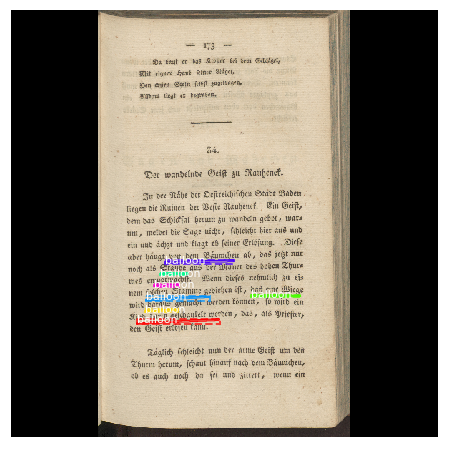

In [40]:
# Test on a random image of validation
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  118.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


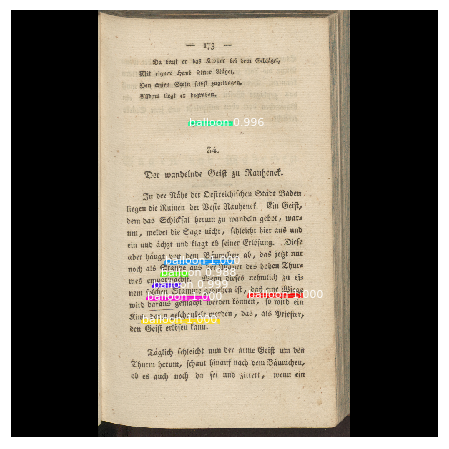

In [41]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

GT Image


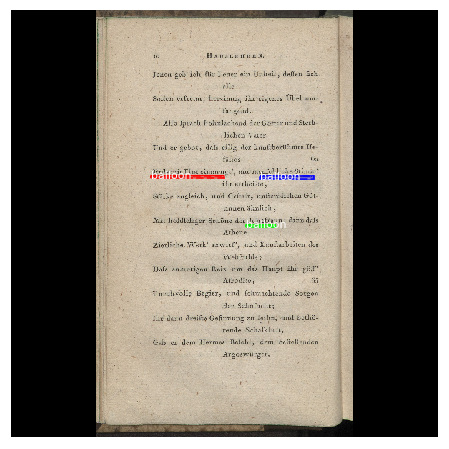

Predicated Image


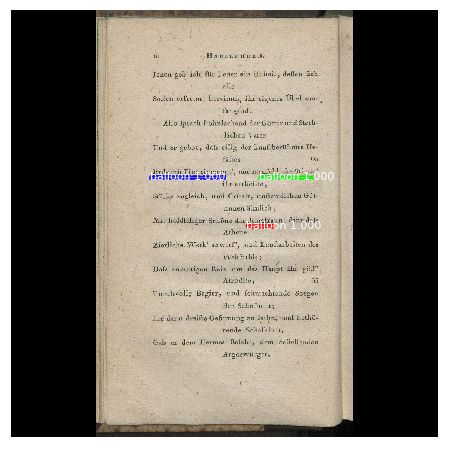

1.0
GT Image


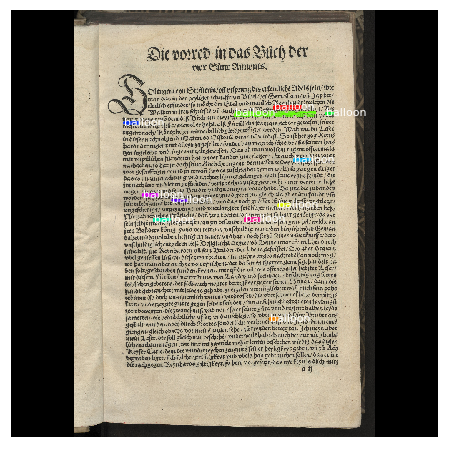

Predicated Image


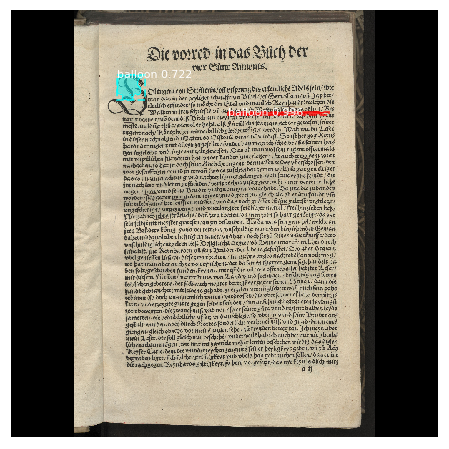

0.09090909361839294
GT Image


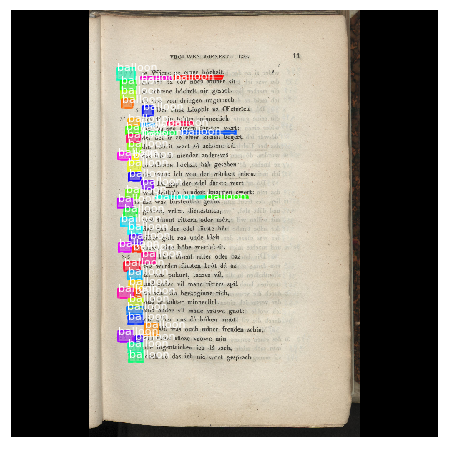

Predicated Image


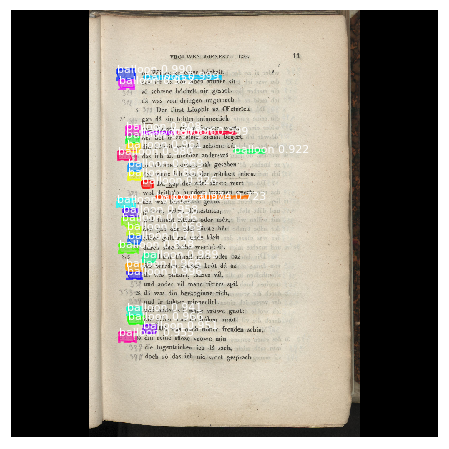

0.5595237846885408
GT Image


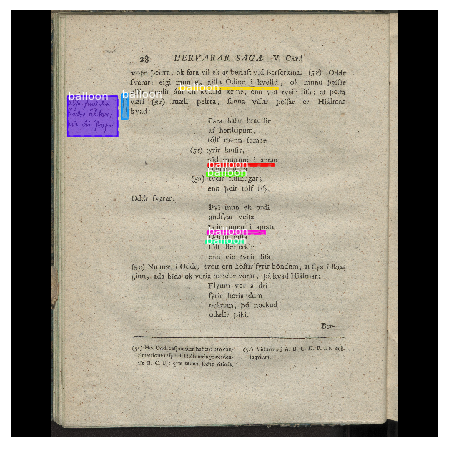

Predicated Image


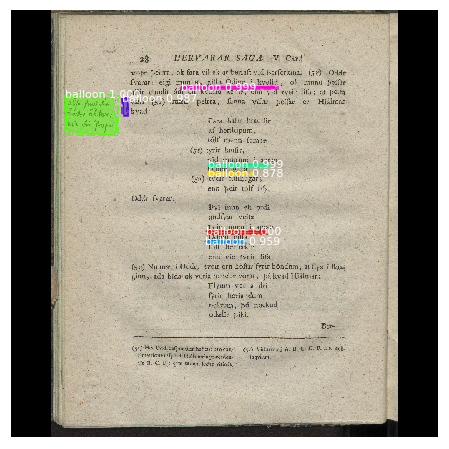

0.8163265415600367
GT Image


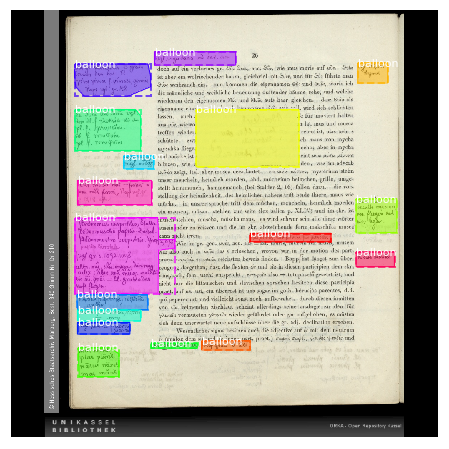

Predicated Image


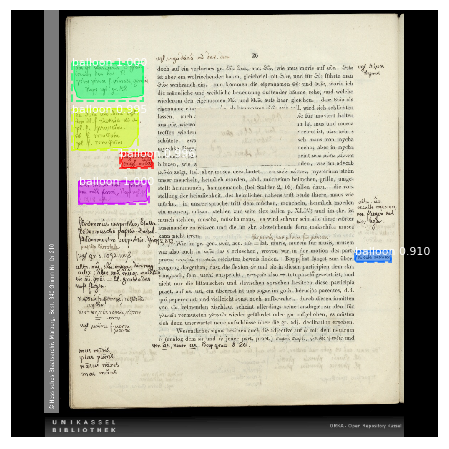

0.29411765933036804
GT Image


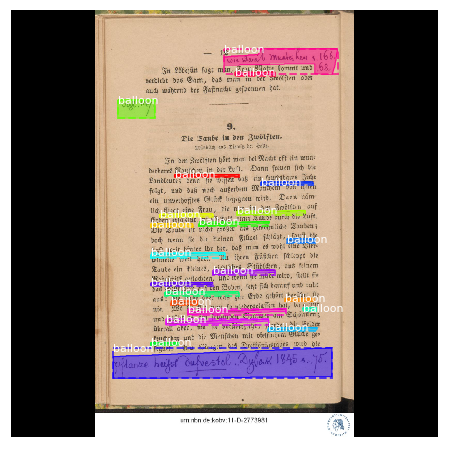

Predicated Image


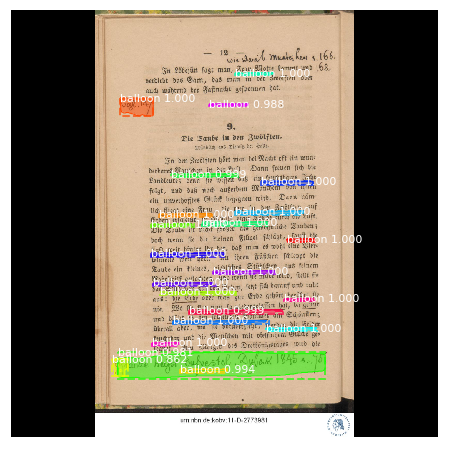

0.8593073685963949
GT Image


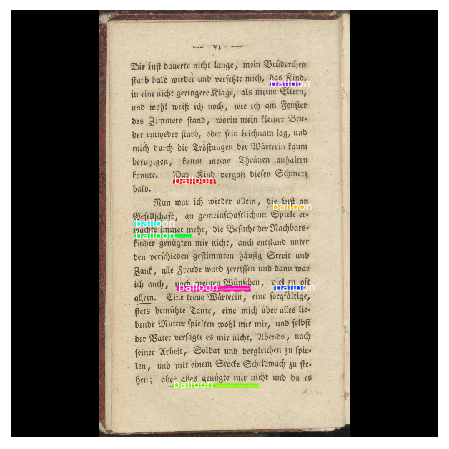

Predicated Image


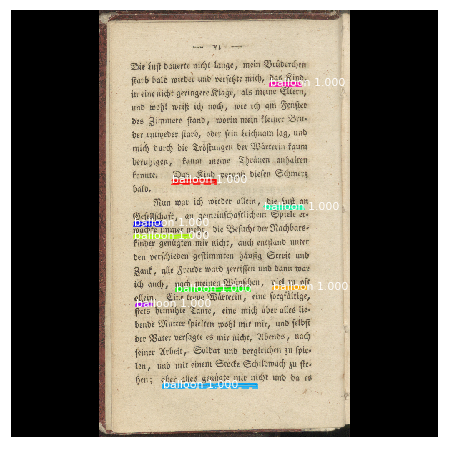

0.3458333333333333
GT Image


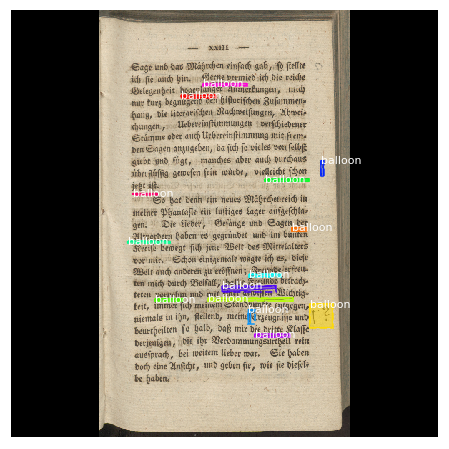

Predicated Image


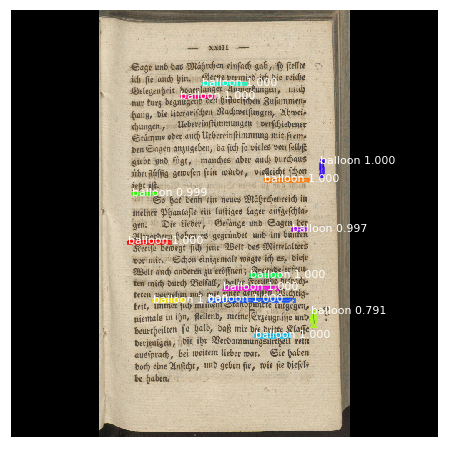

0.7499999850988387
GT Image


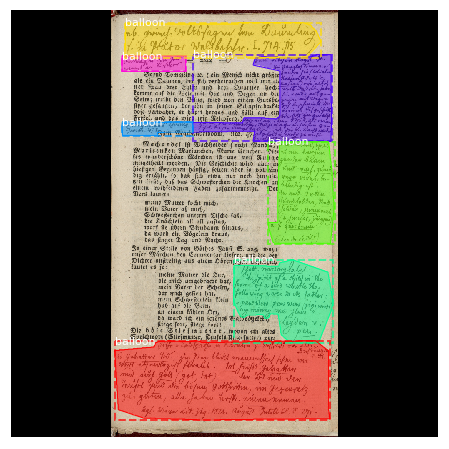

Predicated Image


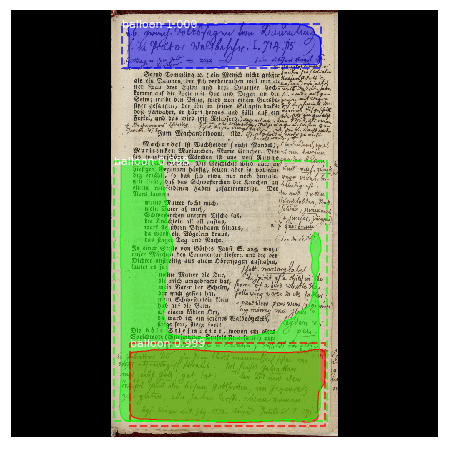

0.2857142984867096
GT Image


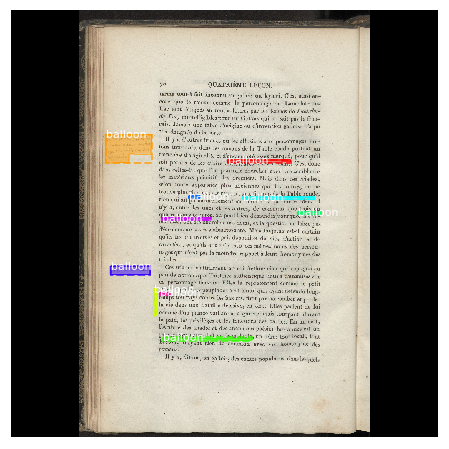

Predicated Image


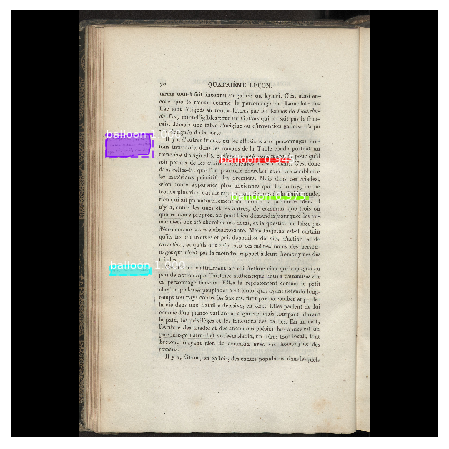

0.30000001192092896
mAP:  0.5301732076633543


In [61]:


# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_test.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Load Ground truth Image with mask
    print('GT Image')
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

    print('Predicated Image')
    # Load Predicated Image with mask
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], figsize=(8, 8))
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])   
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

NameError: name 'history' is not defined